### Ising Model Script ###

In [27]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import time


@njit
def delta_energy_numba(spins, h, J, i, j, L):
    """Compute ΔE for a single site (i, j) using periodic boundaries."""
    spin = spins[i, j]

    ip = (i + 1) % L
    im = (i - 1) % L
    jp = (j + 1) % L
    jm = (j - 1) % L

    neighbors = spins[ip, j] + spins[im, j] + spins[i, jp] + spins[i, jm]
    return 2 * spin * (J * neighbors + h[i, j])
@njit
def metropolis_numba(spins, h, J, kT, num_swaps):
    """Numba-accelerated Metropolis sweep. Updates spins IN PLACE."""
    L = spins.shape[0]
    flips = 0

    for _ in range(num_swaps):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)

        dE = delta_energy_numba(spins, h, J, i, j, L)

        if dE <= 0 or np.random.rand() < np.exp(-dE / kT):
            spins[i, j] = -spins[i, j]
            flips += 1

    return flips



# ============================================================================
# CLASS 1: Spin - Represents a single spin
# ============================================================================
class Spin:
    """Represents a single spin with value +1 or -1"""
    
    def __init__(self, value=None):
        """Initialize spin with random or given value"""
        if value is None:
            self.value = np.random.choice([-1, 1])
        else:
            self.value = value
    
    def flip(self):
        """Flip the spin"""
        self.value *= -1
    
    def __repr__(self):
        return f"Spin({self.value})"


# ============================================================================
# CLASS 2: IsingLattice - Optimized with NumPy backend
# ============================================================================
class IsingLattice:
    """2D lattice of spins with Ising model dynamics (optimized)"""
    
    def __init__(self, L, J=1.0, kT=2.27, h=0.0, initial_state='random'):
        """
        Initialize L x L lattice of spins
        
        Parameters:
        -----------
        L : int
            Lattice size
        J : float
            Coupling constant
        kT : float
            Temperature (in units of J/k_B)
        h : float
        initial_state : str or np.ndarray
            Initial spin configuration:
            - 'random': Random ±1 spins (default)
            - 'up': All spins +1 (ferromagnetic)
            - 'down': All spins -1 (ferromagnetic)
            - 'checkerboard': Alternating ±1 pattern (antiferromagnetic)
            - np.ndarray: Custom L×L configuration
        """
        self.L = L
        self.J = J
        self.kT = kT
        if np.isscalar(h):
            self.h = np.full((L, L), h, dtype=float)
        else:
            if h.shape != (L, L):
                raise ValueError(f"Magnetic field must have shape ({L}, {L})")
            self.h = h.astype(float)
 
        self.initial_state = initial_state  # Store for reset
        self._spin_array = self._initialize_spins(initial_state)
    
    def _initialize_spins(self, initial_state):
        """
        Initialize spins based on initial_state parameter
        
        Parameters:
        -----------
        initial_state : str or np.ndarray
            Type of initial configuration
            
        Returns:
        --------
        np.ndarray : L×L array of ±1 spins
        """
        # Check for custom array FIRST (before string comparisons)
        if isinstance(initial_state, np.ndarray):
            # Custom configuration provided
            if initial_state.shape != (self.L, self.L):
                raise ValueError(f"Custom initial_state must have shape ({self.L}, {self.L})")
            return initial_state.copy()
        
        # Now check string options
        if initial_state == 'random':
            return np.random.choice([-1, 1], size=(self.L, self.L))
        
        elif initial_state == 'up':
            return np.ones((self.L, self.L), dtype=int)
        
        elif initial_state == 'down':
            return -np.ones((self.L, self.L), dtype=int)
        
        elif initial_state == 'checkerboard':
            pattern = np.zeros((self.L, self.L), dtype=int)
            # Create checkerboard pattern
            pattern[::2, ::2] = 1    # Even rows, even columns: +1
            pattern[1::2, 1::2] = 1  # Odd rows, odd columns: +1
            pattern[::2, 1::2] = -1  # Even rows, odd columns: -1
            pattern[1::2, ::2] = -1  # Odd rows, even columns: -1
            return pattern
        
        else:
            raise ValueError(f"Unknown initial_state: {initial_state}. "
                        f"Use 'random', 'up', 'down', 'checkerboard', or provide np.ndarray")
    
    @property
    def spins(self):
        """
        Returns spins as 2D list of Spin objects (for OOP compatibility)
        Only created when accessed (lazy evaluation)
        """
        return [[Spin(value=self._spin_array[m, n]) 
                 for n in range(self.L)] 
                for m in range(self.L)]
    
    def get_spin_value(self, m, n):
        """Get value of spin at position (m, n)"""
        return self._spin_array[m, n]
    
    def flip_spin(self, m, n):
        """Flip spin at position (m, n)"""
        self._spin_array[m, n] *= -1
    
    def get_neighbors_sum(self, m, n):
        """Sum of four nearest neighbors (periodic boundaries)"""
        L = self.L
        return (self._spin_array[(m+1) % L, n] +
                self._spin_array[(m-1) % L, n] +
                self._spin_array[m, (n+1) % L] +
                self._spin_array[m, (n-1) % L])

    '''   
    def delta_energy(self, m, n):
        spin = self._spin_array[m, n]
        neighbors = self.get_neighbors_sum(m, n)
        h_local = self.h[m, n]
        return 2 * spin * (self.J * neighbors + h_local)
  # ← Add field term
    '''

    def set_temperature(self, kT):
        """
        Set the temperature for the simulation
        
        Parameters:
        -----------
        kT : float
            Temperature (in units of J/k_B)
        """
        self.kT = kT
    '''  
    def metropolis(self, kT=None):
        """
        Run Metropolis algorithm at temperature kT (optimized) and 
        return the number of spin flips.
        
        Parameters:
        -----------
        kT : float, optional
            Temperature (if provided, updates self.kT)
        """
        if kT is not None:
            self.kT = kT

        L = self.L
        num_swaps = 1000 * L * L

        # Pre-generate random positions and random acceptance tests
        positions = np.random.randint(0, L, size=(num_swaps, 2))
        randoms = np.random.rand(num_swaps)

        flips = 0  # spin-flip counter

        # Loop over all attempts
        for n in range(num_swaps):
            i, j = positions[n]

            # Compute ΔE using your delta_energy() method
            dE = self.delta_energy(i, j)

            # Accept flip?
            if dE <= 0 or randoms[n] < np.exp(-dE / self.kT):
                self._spin_array[i, j] *= -1
                flips += 1

        return flips   
    '''

    def metropolis(self, kT=None):
        """Call Numba-accelerated Metropolis sweep."""
        if kT is not None:
            self.kT = kT

        num_swaps = 1000 * self.L * self.L

        # Call Numba function (updates array in-place)
        flips = metropolis_numba(
            self._spin_array,
            self.h,
            self.J,
            self.kT,
            num_swaps
        )

        return flips

    
    def magnetization(self):
        """Calculate average magnetization (optimized)"""
        return abs(np.mean(self._spin_array))
    
    def visualize(self, kT=None, title=None):
        """
        Display spin configuration
        
        Parameters:
        -----------
        kT : float, optional
            Temperature for title (uses self.kT if not provided)
        title : str, optional
            Custom title for the plot
        """
        plt.figure(figsize=(6, 6))
        plt.imshow(self._spin_array, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
        
        if title:
            plt.title(title, fontsize=14, fontweight='bold')
        else:
            temp_to_show = kT if kT is not None else self.kT
            plt.title(f"kT = {temp_to_show:.2f}", fontsize=14, fontweight='bold')
        
        plt.colorbar(label='Spin', ticks=[-1, 1])
        plt.tight_layout()
        plt.show()
        
    def reset(self, initial_state=None):
        """
        Reset lattice to initial configuration
        
        Parameters:
        -----------
        initial_state : str or np.ndarray, optional
            If provided, use this configuration
            If None, use the original initial_state from __init__
        """
        if initial_state is None:
            initial_state = self.initial_state
        else:
            self.initial_state = initial_state  # Update stored initial state
        
        self._spin_array = self._initialize_spins(initial_state)


    def set_magnetic_field(self, h):
        """
        Set magnetic field h. Accepts either:
        - scalar (broadcast to LxL)
        - LxL NumPy array
        """
        if np.isscalar(h):
            # Broadcast scalar to full field
            self.h = np.full((self.L, self.L), h, dtype=np.float64)

        else:
            # Convert to array
            h = np.asarray(h)

            # Validate shape
            if h.shape != (self.L, self.L):
                raise ValueError(
                    f"Magnetic field array must have shape ({self.L}, {self.L}), "
                    f"but got {h.shape}"
                )

            # Ensure numba-compatible dtype
            self.h = h.astype(np.float64)


    def metropolis_step(self):
        """
        Perform one Monte Carlo sweep (L²  spin flip attempts)
        """
        L = self.L
        
        for _ in range(L * L):
            m, n = np.random.randint(0, L, size=2)
            dE = self.delta_energy(m, n)
            
            if dE < 0 or np.random.rand() < np.exp(-dE / self.kT):
                self.flip_spin(m, n)
    
    def energy(self):
        """
        Calculate total energy: E = -J Σ⟨i,j⟩ s_i·s_j - h Σ_i s_i
        
        Returns:
        --------
        float : Total energy
        """
        L = self.L
        
        # Part 1: Interaction energy (neighbor coupling)
        # Only count each pair ONCE (right and down neighbors)
        lattice_energy = 0.0
        for m in range(L):
            for n in range(L):
                spin = self._spin_array[m, n]
                right_neighbor = self._spin_array[m, (n+1) % L]
                down_neighbor = self._spin_array[(m+1) % L, n]
                h_local = self.h[m, n]
                # Each pair counted once
                lattice_energy += spin * right_neighbor + spin * down_neighbor + h_local * spin
        
        lattice_energy *= -self.J
        
        
        return float(lattice_energy)

# ============================================================================
# MAIN PROGRAM - Demonstrating different initial states
# ============================================================================
if __name__ == "__main__":
    
    '''
    # Test different initial states
    print("Testing different initial states:\n")
    
    # 1. Random initial state (default)
    lattice_random = IsingLattice(L, initial_state='random')
    print(f"Random: Magnetization = {lattice_random.magnetization():.3f}")
    lattice_random.visualize(title="Initial State: Random")
    
    # 2. All spins up
    lattice_up = IsingLattice(L, initial_state='up')
    print(f"All Up: Magnetization = {lattice_up.magnetization():.3f}")
    lattice_up.visualize(title="Initial State: All Up")
    
    # 3. All spins down
    lattice_down = IsingLattice(L, initial_state='down')
    print(f"All Down: Magnetization = {lattice_down.magnetization():.3f}")
    lattice_down.visualize(title="Initial State: All Down")
    
    # 4. Checkerboard pattern
    lattice_check = IsingLattice(L, initial_state='checkerboard')
    print(f"Checkerboard: Magnetization = {lattice_check.magnetization():.3f}")
    lattice_check.visualize(title="Initial State: Checkerboard")
    
    # 5. Custom initial state (half up, half down)
    custom_config = np.ones((L, L), dtype=int)
    custom_config[:, L//2:] = -1  # Right half is down
    lattice_custom = IsingLattice(L, initial_state=custom_config)
    print(f"Custom (half-half): Magnetization = {lattice_custom.magnetization():.3f}")
    lattice_custom.visualize(title="Initial State: Custom (Half-Half)")
    
    print("\n" + "="*60)
    print("Running temperature sweep with 'up' initial state:")
    print("="*60)
    '''

    L = 50

    
    # Temperature sweep starting from all spins up
    lattice = IsingLattice(L, initial_state='random', kT=1.5, h=1.0)
    temp = np.array([1.5, 1.8, 2.1, 2.2, 2.27, 2.4, 2.5, 2.7, 3.0, 3.5])
    magnetization = []
    
    start_time = time.time()
    
    for kT in temp:
        lattice.reset('up')  # Reset to all up for each temperature
        lattice.metropolis(kT)
        mag = lattice.magnetization()
        magnetization.append(mag)
        print(f"kT = {kT:.2f}: M = {mag:.3f}")
        #lattice.visualize(kT)
    
    end_time = time.time()
    print(f"\nSimulation time: {int(end_time - start_time)} seconds")

kT = 1.50: M = 0.999
kT = 1.80: M = 0.994
kT = 2.10: M = 0.981
kT = 2.20: M = 0.961
kT = 2.27: M = 0.971
kT = 2.40: M = 0.962
kT = 2.50: M = 0.940
kT = 2.70: M = 0.915
kT = 3.00: M = 0.877
kT = 3.50: M = 0.794

Simulation time: 2 seconds


In [28]:
from PIL import Image
import numpy as np

def load_image(path, L, invert=False, h0=2.0):
    """
    Load image, convert to grayscale, resize to L×L, and map pixel intensity → magnetic field.
    
    Parameters
    ----------
    path : str
        Path to image (.png, .jpg)
    L : int
        Lattice size
    invert : bool
        If True: white → spin -1, black → spin +1
        If False: white → spin +1, black → spin -1 (default)
    h0 : float
        Maximum field magnitude
    
    Returns
    -------
    h : ndarray (L, L)
        Local magnetic field
    gray : ndarray (L, L)
        Normalized grayscale version of image
    """
    # Load and convert to grayscale
    img = Image.open(path).convert("L")
    
    # Resize
    img = img.resize((L, L), Image.LANCZOS)
    
    # Convert to np array with values in [0, 1]
    gray = np.asarray(img, dtype=np.float32) / 255.0

    # Optionally invert black/white meaning
    if invert:
        gray = 1 - gray

    # Map grayscale ∈ [0,1] → field ∈ [-h0, +h0]
    h = h0 * (2*gray - 1)  # -1 = black, +1 = white

    return h, gray


In [29]:
def simulated_annealing(L, T_start=4.0, T_end=0.1, cooling_steps=100, 
                       sweeps_per_temp=100, h=0.0, J=1.0, 
                       initial_state='random', cooling='exponential'):
    """
    Simulated annealing: gradually cool system to find ground state
    
    Parameters:
    -----------
    L : int
        Lattice size
    T_start : float
        Starting (high) temperature
    T_end : float
        Ending (low) temperature
    cooling_steps : int
        Number of temperature steps
    sweeps_per_temp : int
        Monte Carlo sweeps at each temperature
    h : float
        External magnetic field
    J : float
        Coupling constant
    initial_state : str or np.ndarray
        Initial spin configuration
    cooling : str
        Cooling schedule: 'exponential' or 'linear'
        
    Returns:
    --------
    lattice : IsingLattice
        Final annealed lattice
    temp_history : np.ndarray
        Temperature at each step
    energy_history : np.ndarray
        Energy at each step
    mag_history : np.ndarray
        Magnetization at each step
    """
    # Create temperature schedule
    if cooling == 'exponential':
        temp_schedule = np.geomspace(T_start, T_end, cooling_steps)
    elif cooling == 'linear':
        temp_schedule = np.linspace(T_start, T_end, cooling_steps)
    else:
        raise ValueError("cooling must be 'exponential' or 'linear'")
    
    # Initialize lattice at high temperature
    lattice = IsingLattice(L=L, J=J, kT=T_start, h=h, initial_state=initial_state)
    
    # History tracking
    temp_history = []
    energy_history = []
    mag_history = []
    
    print("="*70)
    print("SIMULATED ANNEALING")
    print("="*70)
    print(f"Temperature: {T_start:.2f} → {T_end:.2f}")
   #print(f"Magnetic field: h = {h}")
    print(f"Cooling steps: {cooling_steps}")
    print(f"Sweeps per temperature: {sweeps_per_temp}")
    print(f"Cooling schedule: {cooling}")
    print("="*70)
    
    # Annealing loop
    for i, kT in enumerate(temp_schedule):
        lattice.set_temperature(kT)

        # Count flips
        flips_this_temp = []
        for _ in range(sweeps_per_temp):
            flips_this_temp.append(lattice.metropolis())

        # Record observables
        current_energy = lattice.energy()
        current_mag = np.mean(lattice._spin_array)

        temp_history.append(float(kT))
        energy_history.append(float(current_energy))
        mag_history.append(float(current_mag))

        # Progress report
        progress = (i + 1) / cooling_steps * 100
        print(f"  [{progress:5.1f}%] T = {kT:6.3f}, "
            f"E = {current_energy:8.1f}, M = {current_mag:6.3f}")
        print(f"        → Spin flips at this temperature: {flips_this_temp}")

    
    print("="*70)
    print(f"FINAL STATE:")
    print(f"  Temperature: T = {T_end:.3f}")
    print(f"  Energy: E = {energy_history[-1]:.1f}")
    print(f"  Magnetization: M = {mag_history[-1]:.3f}")
    print("="*70)
    
    return (lattice, 
            np.array(temp_history), 
            np.array(energy_history), 
            np.array(mag_history))


def analyze_annealing_with_initial_state(initial_lattice, final_lattice, save_path=None):
    """
    Compare initial and final lattice states and compute integrals
    
    Parameters:
    -----------
    initial_lattice : IsingLattice
        The initial lattice state (before annealing)
    final_lattice : IsingLattice
        The final annealed lattice state
    save_path : str, optional
        Path to save the figure
    """
    L = final_lattice.L
    
    # Get spin arrays
    initial_spins = initial_lattice._spin_array
    final_spins = final_lattice._spin_array
    
    # Box width
    box_width = 1.0
    
    # Compute integrals for both states
    integral_initial = np.sum(initial_spins, axis=0) * box_width
    integral_final = np.sum(final_spins, axis=0) * box_width
    
    x_coords = np.arange(L)
    
    # Create figure
    fig = plt.figure(figsize=(14, 14), dpi=120)
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.25)
    
    # ========================================
    # Plot 1: Initial Lattice
    # ========================================
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(initial_spins, cmap='gray', interpolation='nearest', 
                     vmin=-1, vmax=1, aspect='equal')
    ax1.set_title(f'Initial State (T = {initial_lattice.kT:.2f})', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('y', fontsize=12)
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_ticks([-1, 1])
    
    # ========================================
    # Plot 2: Final Lattice
    # ========================================
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(final_spins, cmap='gray', interpolation='nearest', 
                     vmin=-1, vmax=1, aspect='equal')
    ax2.set_title(f'Final State (T = {final_lattice.kT:.2f})', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel('y', fontsize=12)
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_ticks([-1, 1])
    
    # ========================================
    # Plot 3: Initial Integral
    # ========================================
    ax3 = fig.add_subplot(gs[1, 0])
    colors_init = ['red' if val < 0 else 'blue' for val in integral_initial]
    ax3.bar(x_coords, integral_initial, width=0.8, color=colors_init, 
            alpha=0.7, edgecolor='black', linewidth=0.5)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax3.set_title('Initial Column Integrals', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Column x', fontsize=12)
    ax3.set_ylabel('$\\int$ Spin dy', fontsize=12)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ========================================
    # Plot 4: Final Integral
    # ========================================
    ax4 = fig.add_subplot(gs[1, 1])
    colors_final = ['red' if val < 0 else 'blue' for val in integral_final]
    ax4.bar(x_coords, integral_final, width=0.8, color=colors_final, 
            alpha=0.7, edgecolor='black', linewidth=0.5)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax4.set_title('Final Column Integrals', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Column x', fontsize=12)
    ax4.set_ylabel('$\\int$ Spin dy', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # ========================================
    # Plot 5: Comparison of Integrals
    # ========================================
    ax5 = fig.add_subplot(gs[2, :])
    ax5.plot(x_coords, integral_initial, 'o--', color='orange', 
             linewidth=2, markersize=5, alpha=0.8, label='Initial State')
    ax5.plot(x_coords, integral_final, 's-', color='green', 
             linewidth=2, markersize=5, alpha=0.8, label='Final State (Annealed)')
    ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    ax5.set_title('Comparison: Initial vs Final Column Integrals', 
                  fontsize=14, fontweight='bold')
    ax5.set_xlabel('Column Position x', fontsize=12)
    ax5.set_ylabel('$\\int$ Spin(x,y) dy', fontsize=12)
    ax5.legend(fontsize=12, loc='best')
    ax5.grid(True, alpha=0.3)
    
    # ========================================
    # Statistics
    # ========================================
    stats_text = (
        f"Initial State:\n"
        f"  Total: {np.sum(integral_initial):.1f}\n"
        f"  Mean: {np.mean(integral_initial):.2f}\n"
        f"\n"
        f"Final State:\n"
        f"  Total: {np.sum(integral_final):.1f}\n"
        f"  Mean: {np.mean(integral_final):.2f}\n"
        f"\n"
        f"Change:\n"
        f"  ΔTotal: {np.sum(integral_final) - np.sum(integral_initial):.1f}\n"
        f"  ΔMean: {np.mean(integral_final) - np.mean(integral_initial):.2f}"
    )
    
    fig.text(0.98, 0.02, stats_text, 
             fontsize=9, ha='right', va='bottom',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    fig.suptitle(f'Annealing Analysis: Initial vs Final (L={L}, h={final_lattice.h})', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"[Saved] Comparison analysis → {save_path}")
    
    plt.show()
    
    # Print statistics
    print("\n" + "="*70)
    print("INITIAL vs FINAL STATE COMPARISON")
    print("="*70)
    print(f"Magnetic field: h = {final_lattice.h}")
    print(f"\nInitial State:")
    print(f"  Total integral: {np.sum(integral_initial):.2f}")
    print(f"  Mean per column: {np.mean(integral_initial):.2f}")
    print(f"\nFinal State (Annealed):")
    print(f"  Total integral: {np.sum(integral_final):.2f}")
    print(f"  Mean per column: {np.mean(integral_final):.2f}")
    print(f"\nChange:")
    print(f"  ΔTotal: {np.sum(integral_final) - np.sum(integral_initial):.2f}")
    print(f"  |ΔTotal|: {abs(np.sum(integral_final) - np.sum(integral_initial)):.2f}")
    print("="*70)
    
    return {
        'initial_integral': integral_initial,
        'final_integral': integral_final,
        'change': integral_final - integral_initial
    }

'''
def plot_annealing_results(temps, energies, mags, lattice, save_path=None):
    """
    Plot simulated annealing results
    
    Parameters:
    -----------
    temps : array
        Temperature history
    energies : array
        Energy history
    mags : array
        Magnetization history
    lattice : IsingLattice
        Final lattice state
    save_path : str, optional
        Path to save figure
    """
    fig = plt.figure(figsize=(14, 10), dpi=120)
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Temperature schedule
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(temps, 'o-', color='orange', linewidth=2, markersize=4, alpha=0.8)
    ax1.set_ylabel('Temperature $k_BT$', fontsize=12, fontweight='bold')
    ax1.set_title('Cooling Schedule', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.4)
    ax1.set_xlim(0, len(temps)-1)
    
    # Plot 2: Energy evolution
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(energies, 'o-', color='black', linewidth=2, markersize=4, alpha=0.8)
    ax2.set_ylabel('Energy $E$', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Step', fontsize=12)
    ax2.set_title('Energy Minimization', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.4)
    
    # Plot 3: Magnetization evolution
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(mags, 'o-', color='black', linewidth=2, markersize=4, alpha=0.8)
    ax3.set_ylabel('Magnetization $M$', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Step', fontsize=12)
    ax3.set_title('Magnetization Evolution', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.4)
    
    # Plot 4: Final spin configuration
    ax4 = fig.add_subplot(gs[2, :])
    im = ax4.imshow(lattice._spin_array, cmap='gray', interpolation='nearest', vmin=-1, vmax=1)
    ax4.set_title(f'Final Spin Configuration (T = {temps[-1]:.3f})', 
                  fontsize=14, fontweight='bold')
    ax4.set_xlabel('x', fontsize=12)
    ax4.set_ylabel('y', fontsize=12)
    cbar = plt.colorbar(im, ax=ax4, label='Spin')
    cbar.set_ticks([-1, 1])
    
    # Overall title
    fig.suptitle(f'Simulated Annealing Results (L={lattice.L})', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"\nPlot saved to: {save_path}")
    
    plt.show()
'''

def plot_annealing_results(temps, energies, mags, lattice, save_path=None,
                           final_spin_pdf="final_spin_configuration.pdf"):
    """
    Plot simulated annealing results AND save a clean PDF of the final spin configuration.

    Parameters:
    -----------
    temps : array
        Temperature history
    energies : array
        Energy history
    mags : array
        Magnetization history
    lattice : IsingLattice
        Final lattice state
    save_path : str, optional
        Path to save the combined figure
    final_spin_pdf : str
        Filename for the standalone final-state PDF
    """

    # ======================================================
    # 1) MAIN 4-PANEL FIGURE
    # ======================================================
    fig = plt.figure(figsize=(14, 14), dpi=150)
    gs = fig.add_gridspec(3, 2, hspace=0.32, wspace=0.30)

    # Plot 1: Temperature schedule
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(temps, 'o-', color='tab:orange', linewidth=2, markersize=5, alpha=0.95)
    ax1.set_ylabel('Temperature $k_BT$', fontsize=12, fontweight='bold')
    ax1.set_title('Cooling Schedule', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.35)

    # Plot 2: Energy evolution
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(energies, 'o-', color='tab:blue', linewidth=2, markersize=4, alpha=0.9)
    ax2.set_ylabel('Energy $E$', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Annealing Step', fontsize=12)
    ax2.set_title('Energy Minimization', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.35)

    # Plot 3: Magnetization evolution
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(mags, 'o-', color='tab:red', linewidth=2, markersize=4, alpha=0.9)
    ax3.set_ylabel('Magnetization $M$', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Annealing Step', fontsize=12)
    ax3.set_title('Magnetization Evolution', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.35)

    # Plot 4: Final spin configuration
    ax4 = fig.add_subplot(gs[2, :])
    im = ax4.imshow(lattice._spin_array, cmap='gray', interpolation='nearest',
                    vmin=-1, vmax=1)
    ax4.set_title(
        f'Final Spin Configuration (T = {temps[-1]:.3f})',
        fontsize=14, fontweight='bold'
    )
    ax4.set_xlabel('x', fontsize=12)
    ax4.set_ylabel('y', fontsize=12)

    # A cleaner, nicer looking colorbar
    cbar = plt.colorbar(im, ax=ax4, shrink=0.85, pad=0.02)
    cbar.set_label('Spin Value', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)

    # Global title
    fig.suptitle(
        f'Simulated Annealing Results (L = {lattice.L})',
        fontsize=18, fontweight='bold', y=1.02
    )

    # Save combined figure if requested
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"[Saved] Full annealing results → {save_path}")

    plt.show()


    # ======================================================
    # 2) STANDALONE FINAL SPIN CONFIGURATION PDF
    # ======================================================

    fig2 = plt.figure(figsize=(6, 6), dpi=300)

    plt.imshow(lattice._spin_array,
               cmap='gray',
               interpolation='nearest',
               vmin=-1, vmax=1)

    plt.title(f"Final Spin Configuration (L={lattice.L}, T={temps[-1]:.3f})",
              fontsize=16, fontweight='bold', pad=12)

    plt.xlabel("x", fontsize=14)
    plt.ylabel("y", fontsize=14)


    plt.tight_layout()

    fig2.savefig(final_spin_pdf, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close(fig2)

    print(f"[Saved] Final spin PDF → {final_spin_pdf}")




Example 2: With magnetic field h = 0.5
SIMULATED ANNEALING
Temperature: 4.00 → 0.10
Cooling steps: 10
Sweeps per temperature: 2
Cooling schedule: exponential
  [ 10.0%] T =  4.000, E =   1722.7, M =  0.216
        → Spin flips at this temperature: [1518955, 1519989]
  [ 20.0%] T =  2.655, E =   2273.7, M =  0.273
        → Spin flips at this temperature: [1298254, 1298405]
  [ 30.0%] T =  1.762, E =   2645.4, M =  0.322
        → Spin flips at this temperature: [1090564, 1090456]
  [ 40.0%] T =  1.170, E =   3181.9, M =  0.352
        → Spin flips at this temperature: [902617, 903650]
  [ 50.0%] T =  0.776, E =   3773.6, M =  0.415
        → Spin flips at this temperature: [727746, 726807]
  [ 60.0%] T =  0.515, E =   4281.0, M =  0.445
        → Spin flips at this temperature: [553348, 553253]
  [ 70.0%] T =  0.342, E =   4957.6, M =  0.490
        → Spin flips at this temperature: [373724, 372944]
  [ 80.0%] T =  0.227, E =   5597.8, M =  0.546
        → Spin flips at this temperat

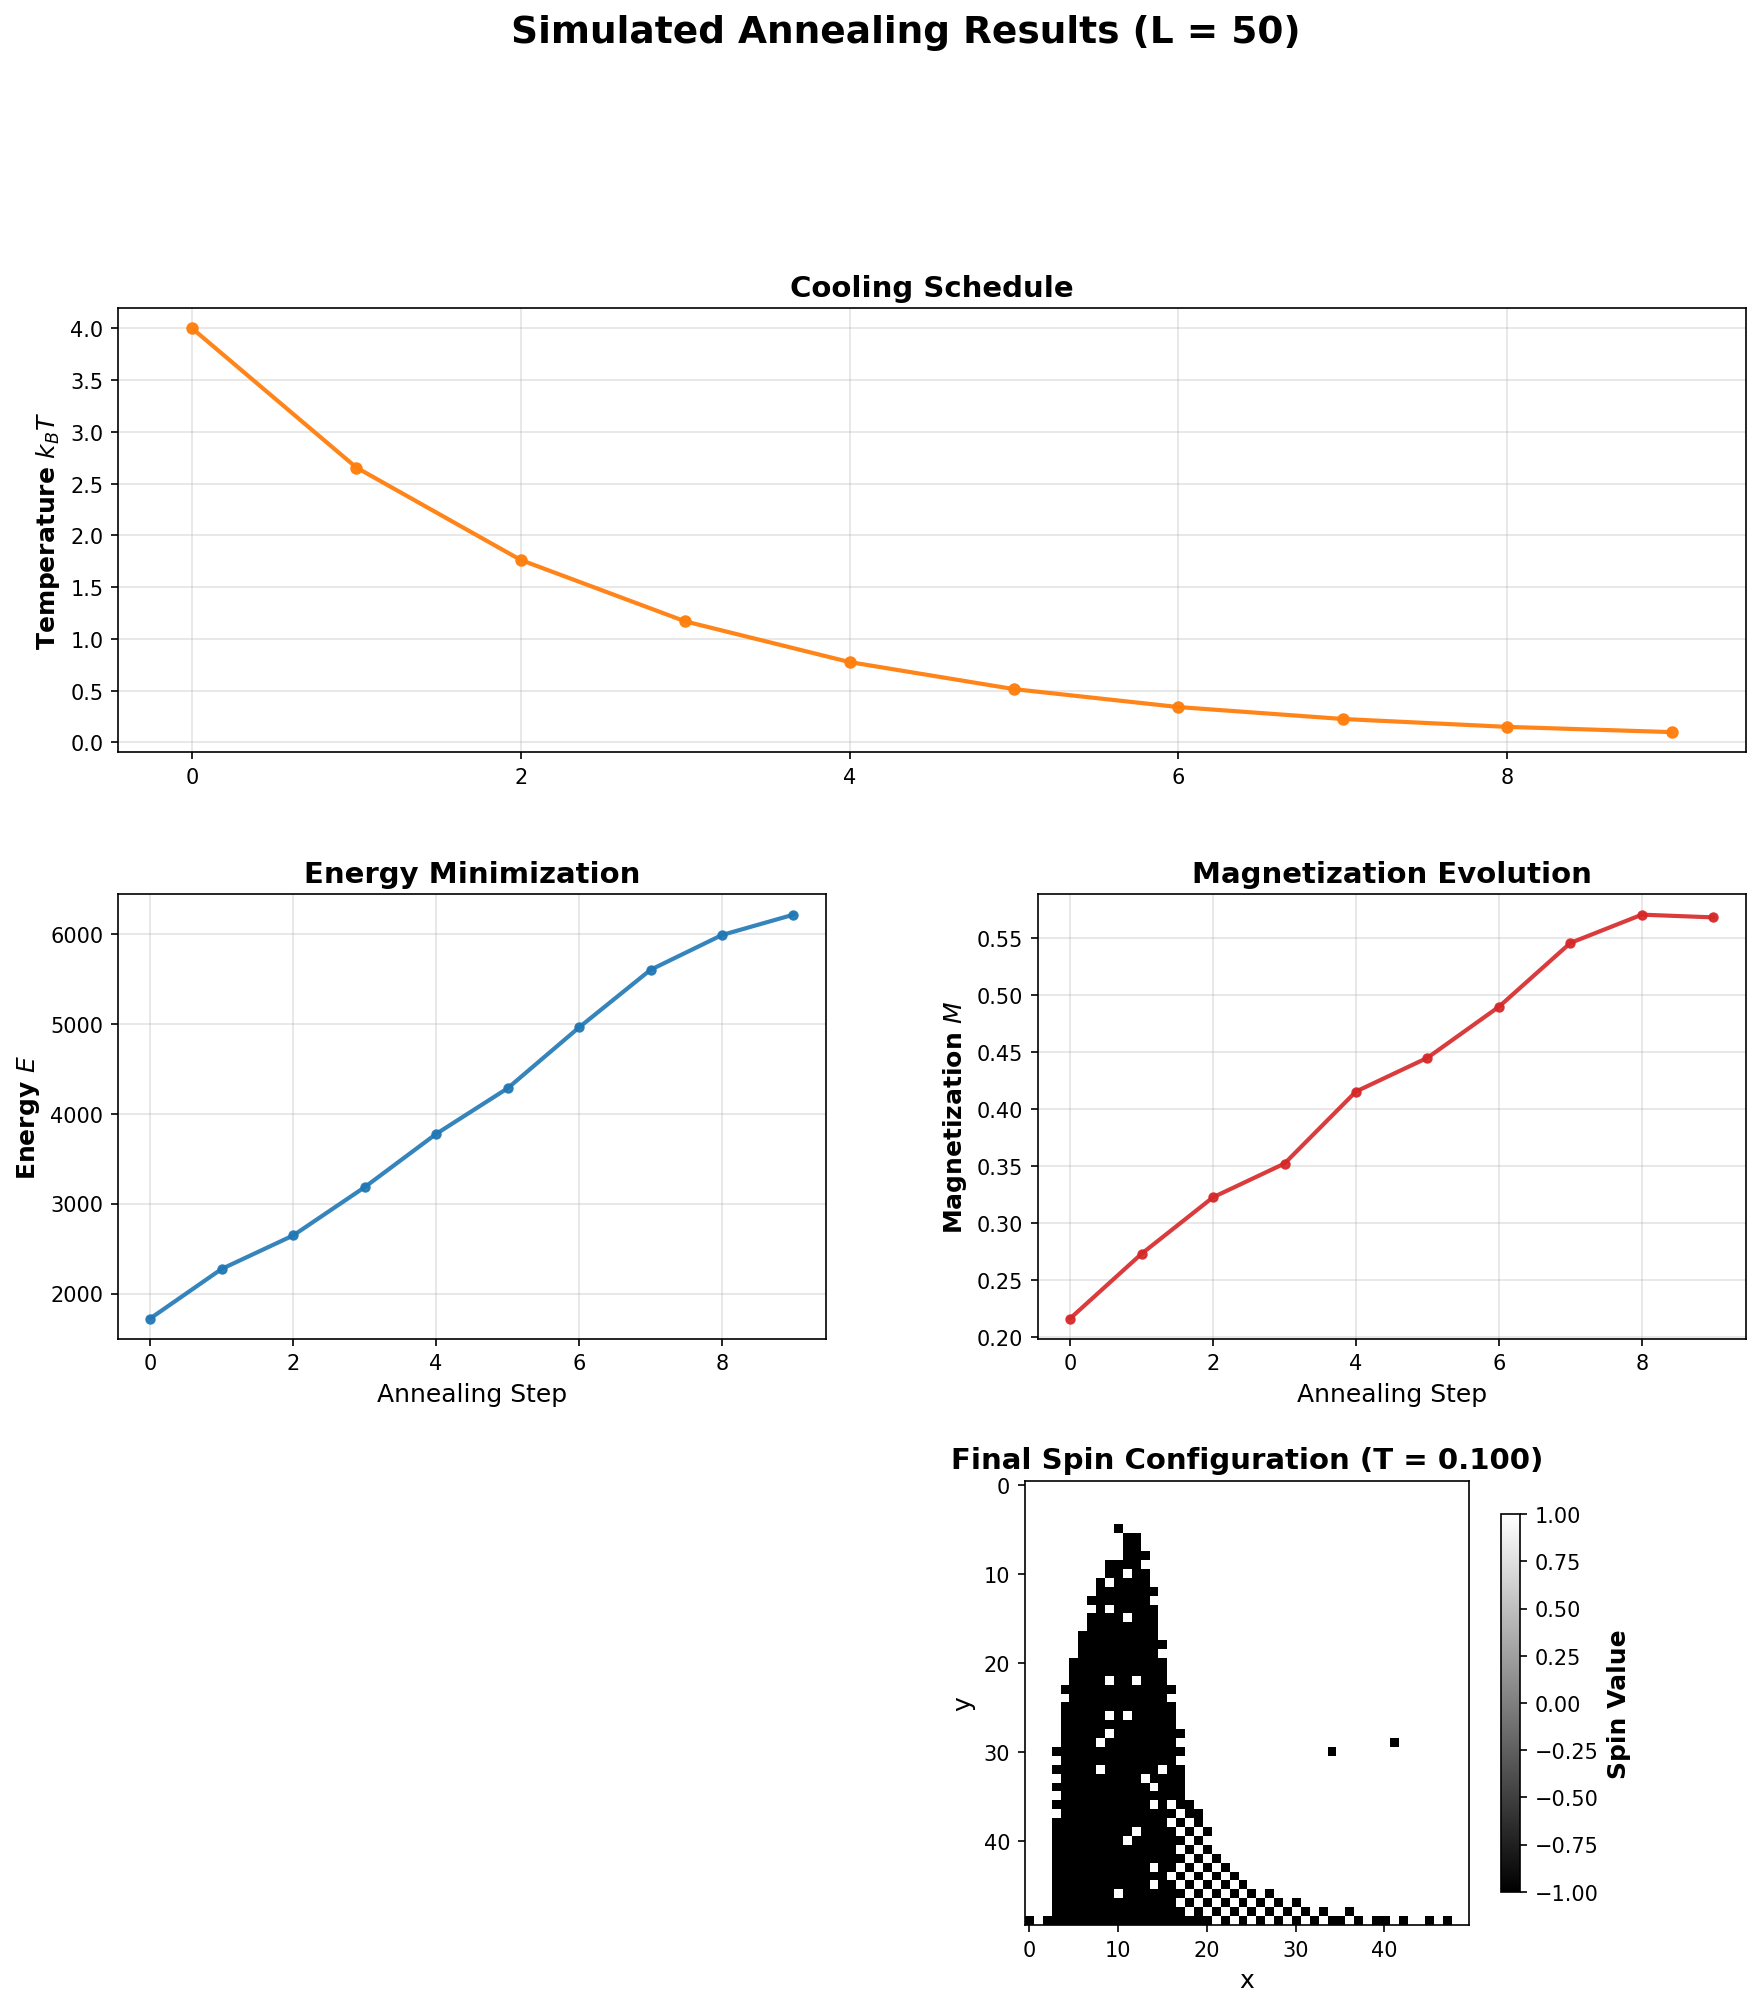

[Saved] Final spin PDF → /Users/mattthew/Documents/GitHub/Comp-Sim-Numerical-Methods/IsingModel/picture to plot/blue.plot.ising.png


In [30]:
# Example 2: With magnetic field (spins align with field)
print("\n" + "="*70 + "\n")
print("Example 2: With magnetic field h = 0.5")
h_field, gray = load_image("/Users/mattthew/Documents/GitHub/Comp-Sim-Numerical-Methods/IsingModel/picture to plot/blue.plot.png", L=50, h0=3.0)
lattice2, temps2, energies2, mags2 = simulated_annealing(
    L=50,
    T_start=4.0,
    T_end=0.1,
    cooling_steps=10,
    sweeps_per_temp=2,
    h=h_field,  # Positive field favors spin-up
    J=-0.6,
    initial_state='random',
    cooling='exponential'
)


plot_annealing_results(
    temps2,
    energies2,
    mags2,
    lattice2,
    save_path='/Users/mattthew/Documents/GitHub/Comp-Sim-Numerical-Methods/IsingModel/picture to plot/blue.plot.metrics.png',
    final_spin_pdf='/Users/mattthew/Documents/GitHub/Comp-Sim-Numerical-Methods/IsingModel/picture to plot/blue.plot.ising.png'
)

In [31]:
def plot_highest_black_dot_profile(lattice, save_path=None):
    """
    Find the highest black dot (spin = -1) in each column and plot it
    
    Parameters:
    -----------
    lattice : IsingLattice
        The annealed lattice
    save_path : str, optional
        Path to save the figure
        
    Returns:
    --------
    dict : Contains x_coords and y_highest arrays
    """
    L = lattice.L
    spin_array = lattice._spin_array
    
    # Find highest (lowest y-index) black dot in each column
    y_highest = []
    x_coords = []
    
    for x in range(L):
        column = spin_array[:, x]
        # Find all black dots (spin = -1) in this column
        black_indices = np.where(column == -1)[0]
        
        if len(black_indices) > 0:
            # Lowest index = highest position (since y=0 is at top)
            highest_black = black_indices[0]
            y_highest.append(highest_black)
            x_coords.append(x)
        else:
            # No black dots in this column
            y_highest.append(np.nan)  # Use NaN to skip
            x_coords.append(x)
    
    y_highest = np.array(y_highest)
    x_coords = np.array(x_coords)
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=120)
    
    # ========================================
    # Plot 1: Lattice with overlay
    # ========================================
    ax1.imshow(spin_array, cmap='gray', interpolation='nearest', 
               vmin=-1, vmax=1, aspect='equal', origin='upper')
    
    # Overlay the highest black dots
    valid_mask = ~np.isnan(y_highest)
    ax1.plot(x_coords[valid_mask], y_highest[valid_mask], 
             'r-', linewidth=2.5, alpha=0.9, label='Highest Black Dot Profile')
    ax1.scatter(x_coords[valid_mask], y_highest[valid_mask], 
                c='red', s=10, alpha=0.7, zorder=5)
    
    ax1.set_title(f'Spin Configuration with Highest Black Dot Profile (L={L})', 
                  fontsize=16, fontweight='bold')
    ax1.set_xlabel('Column (x)', fontsize=13)
    ax1.set_ylabel('Row (y)', fontsize=13)
    ax1.legend(fontsize=12, loc='upper right')
    ax1.set_xlim(0, L-1)
    ax1.set_ylim(L-1, 0)  # Invert y-axis to match image convention
    
    # ========================================
    # Plot 2: Profile graph (flipped for intuitive view)
    # ========================================
    # Flip y-values so "highest" means highest on graph
    y_flipped = L - 1 - y_highest
    
    ax2.plot(x_coords, y_flipped, 'o-', color='darkblue', 
             linewidth=2, markersize=4, alpha=0.8)
    ax2.fill_between(x_coords, 0, y_flipped, alpha=0.3, color='blue')
    
    ax2.set_title('Height Profile: Highest Black Dot in Each Column', 
                  fontsize=16, fontweight='bold')
    ax2.set_xlabel('Column Position (x)', fontsize=13)
    ax2.set_ylabel('Height (pixels from bottom)', fontsize=13)
    ax2.grid(True, alpha=0.4)
    ax2.set_xlim(0, L-1)
    ax2.set_ylim(0, L)
    
    # Add statistics
    valid_heights = y_flipped[valid_mask]
    if len(valid_heights) > 0:
        stats_text = (
            f"Statistics:\n"
            f"Mean height: {np.nanmean(valid_heights):.1f}\n"
            f"Max height: {np.nanmax(valid_heights):.1f}\n"
            f"Min height: {np.nanmin(valid_heights):.1f}\n"
            f"Std dev: {np.nanstd(valid_heights):.1f}\n"
            f"Columns with black: {np.sum(valid_mask)}/{L}"
        )
    else:
        stats_text = "No black dots found!"
    
    ax2.text(0.98, 0.97, stats_text, transform=ax2.transAxes,
             fontsize=10, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"[Saved] Profile analysis → {save_path}")
    
    plt.show()
    
    # Print summary
    print("\n" + "="*70)
    print("HIGHEST BLACK DOT PROFILE ANALYSIS")
    print("="*70)
    print(f"Lattice size: {L} × {L}")
    print(f"Columns analyzed: {L}")
    print(f"Columns with black dots: {np.sum(valid_mask)}")
    print(f"Columns without black dots: {L - np.sum(valid_mask)}")
    if len(valid_heights) > 0:
        print(f"\nHeight Statistics (from bottom):")
        print(f"  Mean: {np.nanmean(valid_heights):.2f}")
        print(f"  Median: {np.nanmedian(valid_heights):.2f}")
        print(f"  Max: {np.nanmax(valid_heights):.2f}")
        print(f"  Min: {np.nanmin(valid_heights):.2f}")
    print("="*70)
    
    return {
        'x_coords': x_coords,
        'y_highest_raw': y_highest,  # Raw y-indices (0 = top)
        'y_highest_flipped': y_flipped,  # Flipped (0 = bottom)
        'valid_mask': valid_mask
    }

In [33]:
def rescale_profile_to_height(profile_data, target_max_height, lattice=None, save_path=None):
    """
    Rescale the height profile so its maximum matches a target height
    
    Parameters:
    -----------
    profile_data : dict
        Output from plot_highest_black_dot_profile()
    target_max_height : float
        Desired maximum height in the rescaled profile
    lattice : IsingLattice, optional
        Original lattice for visualization
    save_path : str, optional
        Path to save figure
        
    Returns:
    --------
    dict : Contains rescaled data
    """
    x_coords = profile_data['x_coords']
    y_heights = profile_data['y_highest_flipped']
    valid_mask = profile_data['valid_mask']
    
    # Get valid heights only
    valid_heights = y_heights[valid_mask]
    valid_x = x_coords[valid_mask]
    
    # Find current min and max
    current_min = np.nanmin(valid_heights)
    current_max = np.nanmax(valid_heights)
    current_range = current_max - current_min
    
    # Rescale to target height
    # Formula: y_new = (y_old - min) * (target_max / range)
    if current_range > 0:
        rescaled_heights = (y_heights - current_min) * (target_max_height / current_range)
    else:
        rescaled_heights = np.zeros_like(y_heights)
    
    # Apply valid mask (keep NaN where there were no black dots)
    rescaled_heights[~valid_mask] = np.nan
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 16), dpi=120)
    
    # ========================================
    # Plot 1: Original lattice (if provided)
    # ========================================
    if lattice is not None:
        ax1 = axes[0, 0]
        ax1.imshow(lattice._spin_array, cmap='gray', interpolation='nearest', 
                   vmin=-1, vmax=1, aspect='equal', origin='upper')
        ax1.plot(valid_x, lattice.L - 1 - (valid_heights + current_min), 
                 'r-', linewidth=2, alpha=0.9, label='Original Profile')
        ax1.set_title(f'Original Lattice (L={lattice.L})', fontsize=14, fontweight='bold')
        ax1.set_xlabel('x', fontsize=12)
        ax1.set_ylabel('y', fontsize=12)
        ax1.legend(fontsize=10)
        ax1.set_xlim(0, lattice.L-1)
        ax1.set_ylim(lattice.L-1, 0)
    else:
        axes[0, 0].text(0.5, 0.5, 'No lattice provided', 
                       ha='center', va='center', fontsize=14)
        axes[0, 0].axis('off')
    
    # ========================================
    # Plot 2: Original profile
    # ========================================
    ax2 = axes[0, 1]
    ax2.plot(x_coords, y_heights, 'o-', color='darkblue', 
             linewidth=2, markersize=4, alpha=0.8, label='Original')
    ax2.fill_between(x_coords, 0, y_heights, alpha=0.3, color='blue')
    ax2.axhline(y=current_max, color='red', linestyle='--', 
                linewidth=1.5, alpha=0.7, label=f'Max = {current_max:.1f}')
    
    ax2.set_title('Original Height Profile', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Column Position (x)', fontsize=12)
    ax2.set_ylabel('Height (pixels)', fontsize=12)
    ax2.legend(fontsize=11, loc='upper right')
    ax2.grid(True, alpha=0.4)
    ax2.set_xlim(0, len(x_coords)-1)
    
    # ========================================
    # Plot 3: Rescaled profile
    # ========================================
    ax3 = axes[1, 0]
    ax3.plot(x_coords, rescaled_heights, 'o-', color='darkgreen', 
             linewidth=2, markersize=4, alpha=0.8, label='Rescaled')
    ax3.fill_between(x_coords, 0, rescaled_heights, alpha=0.3, color='green')
    ax3.axhline(y=target_max_height, color='red', linestyle='--', 
                linewidth=1.5, alpha=0.7, label=f'Target Max = {target_max_height:.1f}')
    
    ax3.set_title(f'Rescaled Height Profile (Max = {target_max_height})', 
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel('Column Position (x)', fontsize=12)
    ax3.set_ylabel('Height (rescaled)', fontsize=12)
    ax3.legend(fontsize=11, loc='upper right')
    ax3.grid(True, alpha=0.4)
    ax3.set_xlim(0, len(x_coords)-1)
    ax3.set_ylim(0, target_max_height * 1.1)
    
    # ========================================
    # Plot 4: Comparison overlay
    # ========================================
    ax4 = axes[1, 1]
    
    # Normalize both to [0, 1] for comparison
    norm_original = (y_heights - current_min) / current_range if current_range > 0 else y_heights
    norm_rescaled = rescaled_heights / target_max_height
    
    ax4.plot(x_coords, norm_original, 'o-', color='blue', 
             linewidth=2, markersize=3, alpha=0.7, label='Original (normalized)')
    ax4.plot(x_coords, norm_rescaled, 's-', color='green', 
             linewidth=2, markersize=3, alpha=0.7, label='Rescaled (normalized)')
    
    ax4.set_title('Comparison (Both Normalized to [0,1])', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Column Position (x)', fontsize=12)
    ax4.set_ylabel('Normalized Height', fontsize=12)
    ax4.legend(fontsize=11, loc='upper right')
    ax4.grid(True, alpha=0.4)
    ax4.set_xlim(0, len(x_coords)-1)
    ax4.set_ylim(-0.05, 1.05)
    
    # Add statistics box
    stats_text = (
        f"Rescaling Summary:\n"
        f"Original max: {current_max:.1f}\n"
        f"Original min: {current_min:.1f}\n"
        f"Original range: {current_range:.1f}\n"
        f"\n"
        f"Target max: {target_max_height:.1f}\n"
        f"Scale factor: {target_max_height/current_range:.3f}"
    )
    
    fig.text(0.99, 0.01, stats_text, 
             fontsize=9, ha='right', va='bottom',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"[Saved] Rescaled profile → {save_path}")
    
    plt.show()
    
    # Print summary
    print("\n" + "="*70)
    print("HEIGHT PROFILE RESCALING")
    print("="*70)
    print(f"Original height range: [{current_min:.2f}, {current_max:.2f}]")
    print(f"Target maximum height: {target_max_height:.2f}")
    print(f"Scale factor: {target_max_height/current_range:.4f}")
    print(f"Valid data points: {np.sum(valid_mask)}/{len(x_coords)}")
    print("="*70)
    
    return {
        'x_coords': x_coords,
        'original_heights': y_heights,
        'rescaled_heights': rescaled_heights,
        'target_max': target_max_height,
        'scale_factor': target_max_height / current_range if current_range > 0 else 0,
        'valid_mask': valid_mask
    }

SIMULATED ANNEALING
Temperature: 4.00 → 0.10
Cooling steps: 10
Sweeps per temperature: 2
Cooling schedule: exponential
  [ 10.0%] T =  4.000, E =  20773.7, M =  0.368
        → Spin flips at this temperature: [3877733, 3875657]
  [ 20.0%] T =  2.655, E =  25746.3, M =  0.428
        → Spin flips at this temperature: [2610889, 2609747]
  [ 30.0%] T =  1.762, E =  31257.3, M =  0.485
        → Spin flips at this temperature: [1459134, 1456385]
  [ 40.0%] T =  1.170, E =  35248.1, M =  0.524
        → Spin flips at this temperature: [608159, 608364]
  [ 50.0%] T =  0.776, E =  36972.9, M =  0.542
        → Spin flips at this temperature: [203154, 203593]
  [ 60.0%] T =  0.515, E =  37332.5, M =  0.541
        → Spin flips at this temperature: [87716, 87186]
  [ 70.0%] T =  0.342, E =  37415.0, M =  0.542
        → Spin flips at this temperature: [51014, 50344]
  [ 80.0%] T =  0.227, E =  37448.4, M =  0.540
        → Spin flips at this temperature: [28863, 29319]
  [ 90.0%] T =  0.151, E 

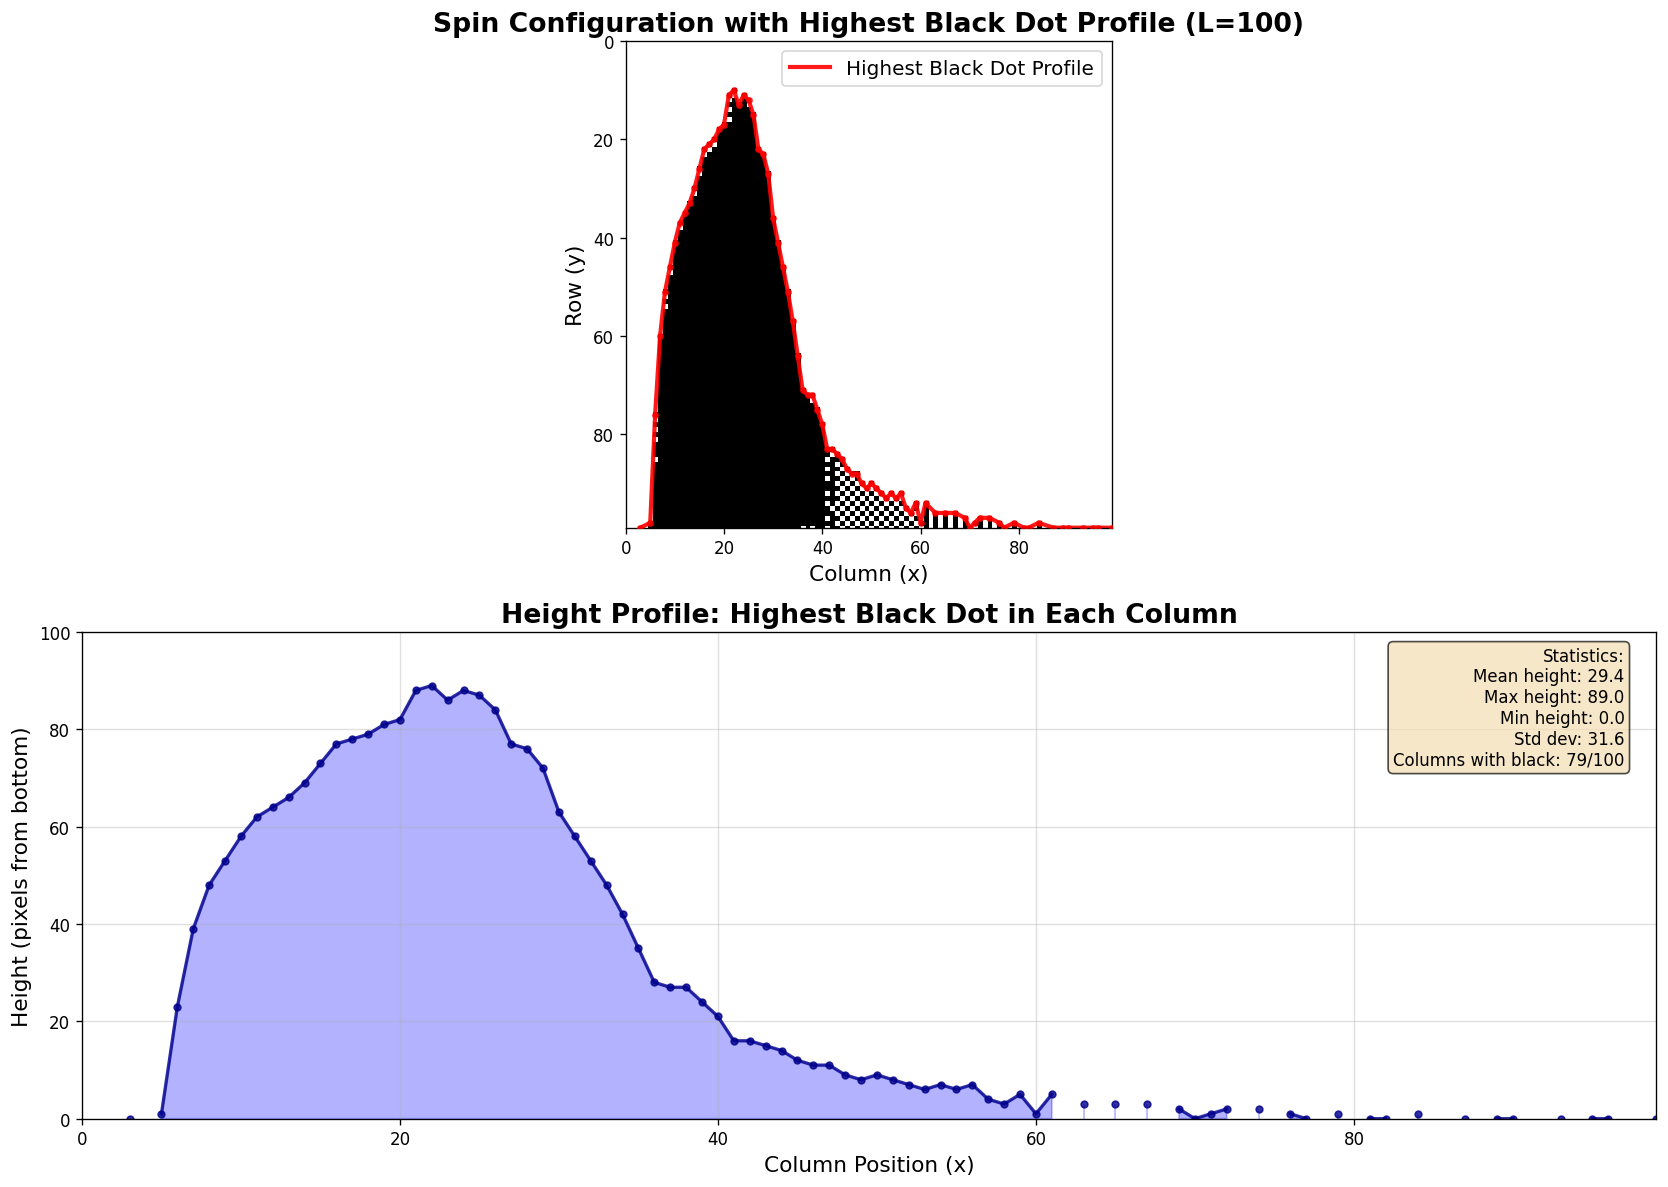


HIGHEST BLACK DOT PROFILE ANALYSIS
Lattice size: 100 × 100
Columns analyzed: 100
Columns with black dots: 79
Columns without black dots: 21

Height Statistics (from bottom):
  Mean: 29.43
  Median: 12.00
  Max: 89.00
  Min: 0.00
[Saved] Rescaled profile → blue_plot_rescaled_profile.pdf


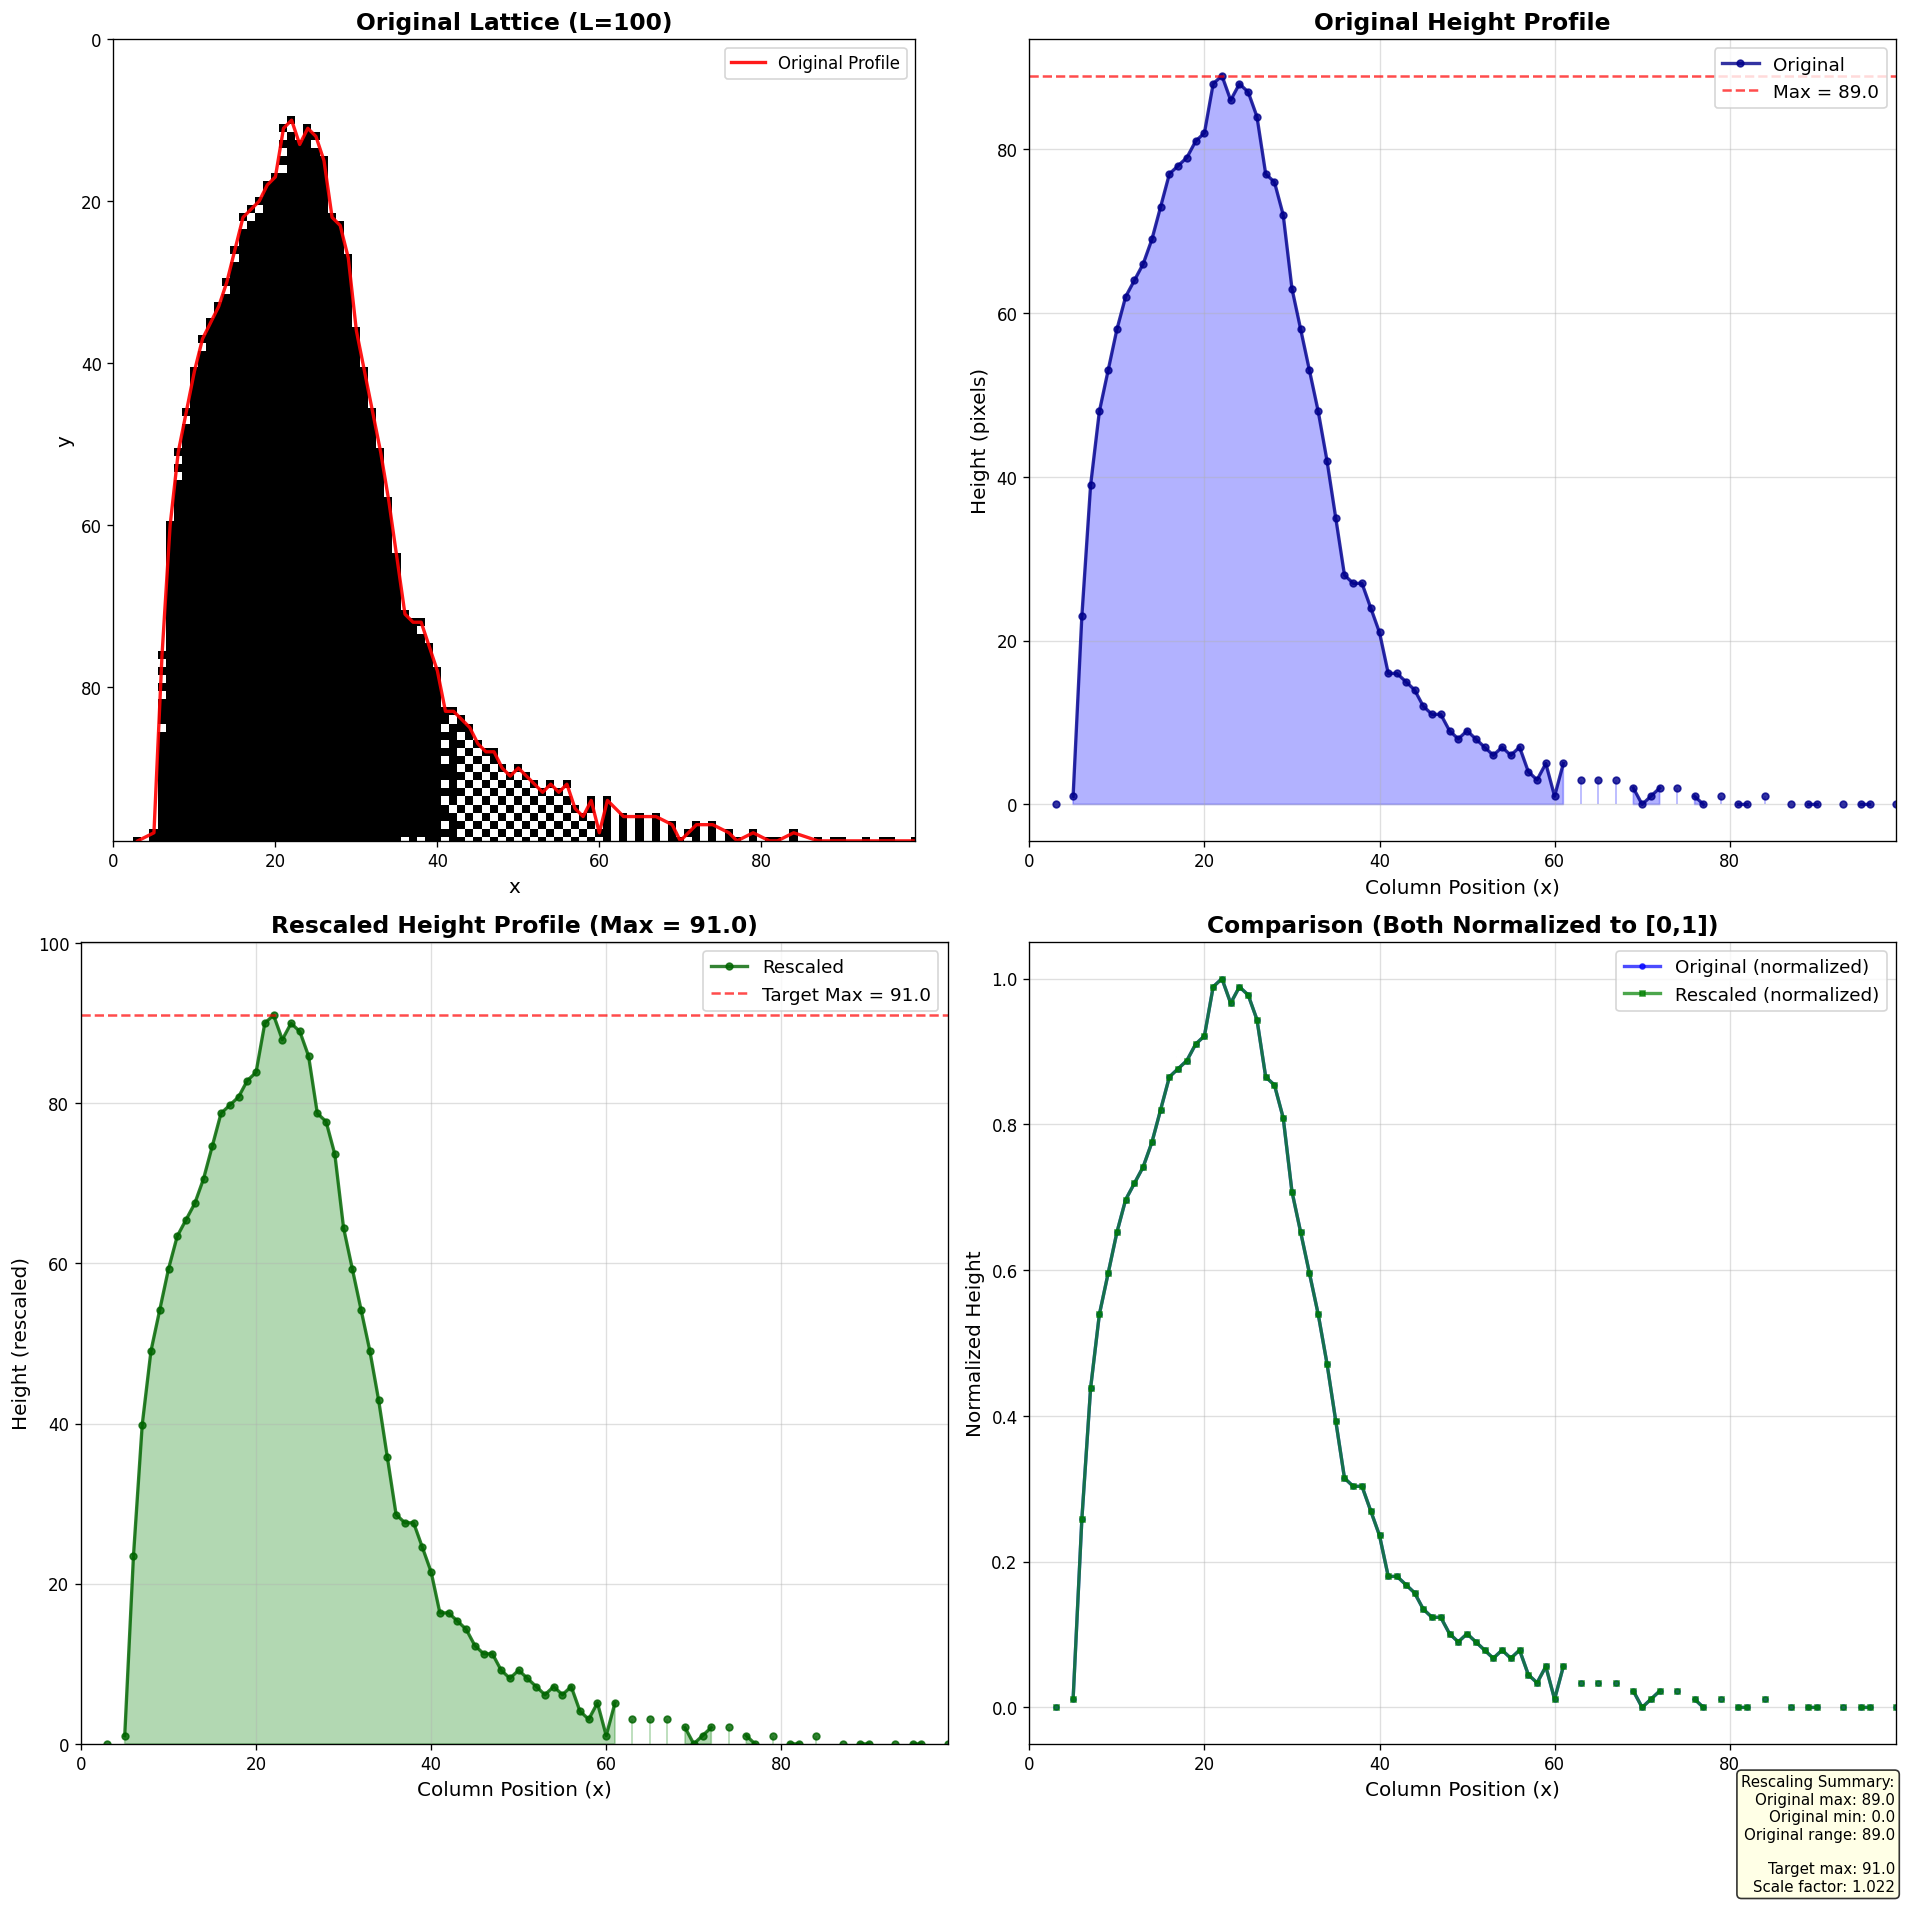


HEIGHT PROFILE RESCALING
Original height range: [0.00, 89.00]
Target maximum height: 91.00
Scale factor: 1.0225
Valid data points: 79/100


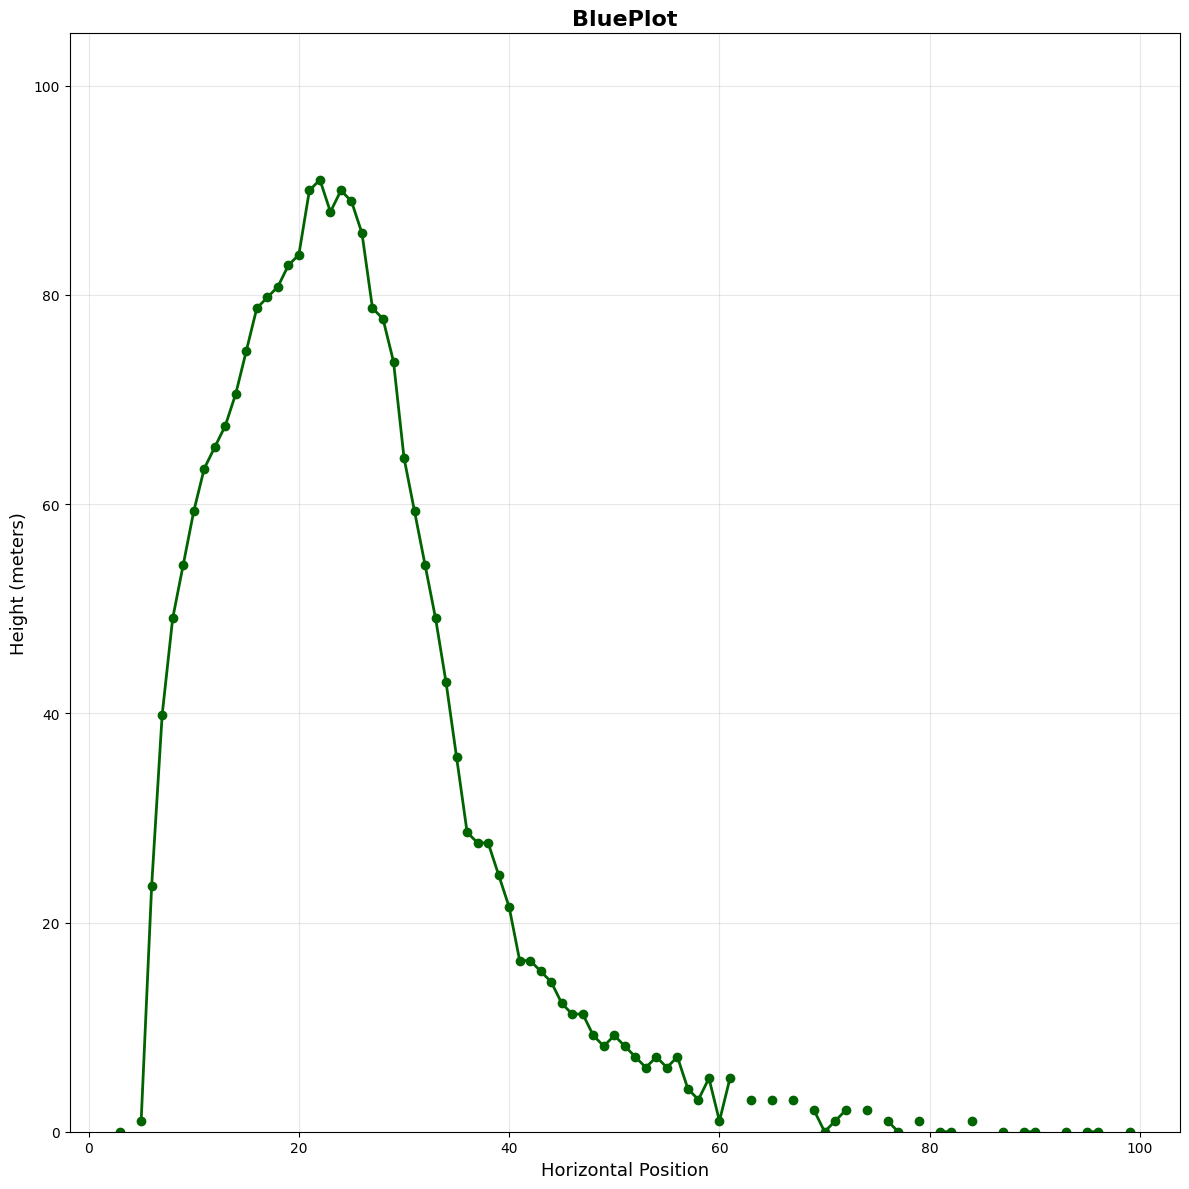

In [34]:
# Step 1: Run annealing
h_field, gray = load_image(
    "/Users/mattthew/Documents/GitHub/Comp-Sim-Numerical-Methods/IsingModel/picture to plot/blue.plot.png", 
    L=100, h0=5.0
)

lattice2, temps2, energies2, mags2 = simulated_annealing(
    L=100, T_start=4.0, T_end=0.1, cooling_steps=10, sweeps_per_temp=2,
    h=h_field, J=-0.6, initial_state='random', cooling='exponential'
)

# Step 2: Extract profile
profile_data = plot_highest_black_dot_profile(
    lattice2,
    save_path='bluePlot_profile.pdf'
)

# Step 3: Rescale to target height (e.g., 100 meters)
rescaled_data = rescale_profile_to_height(
    profile_data,
    target_max_height=91.0,  # Target maximum height
    lattice=lattice2,
    save_path='blue_plot_rescaled_profile.pdf'
)

# Step 4: Use the rescaled data
x_positions = rescaled_data['x_coords']
heights_rescaled = rescaled_data['rescaled_heights']

# Plot just the rescaled profile
plt.figure(figsize=(12, 12))
plt.plot(x_positions, heights_rescaled, 'o-', linewidth=2, color='darkgreen')
plt.title('BluePlot', fontsize=16, fontweight='bold')
plt.xlabel('Horizontal Position', fontsize=13)
plt.ylabel('Height (meters)', fontsize=13)
plt.grid(True, alpha=0.3)
plt.ylim(0, 105)
plt.tight_layout()
plt.show()

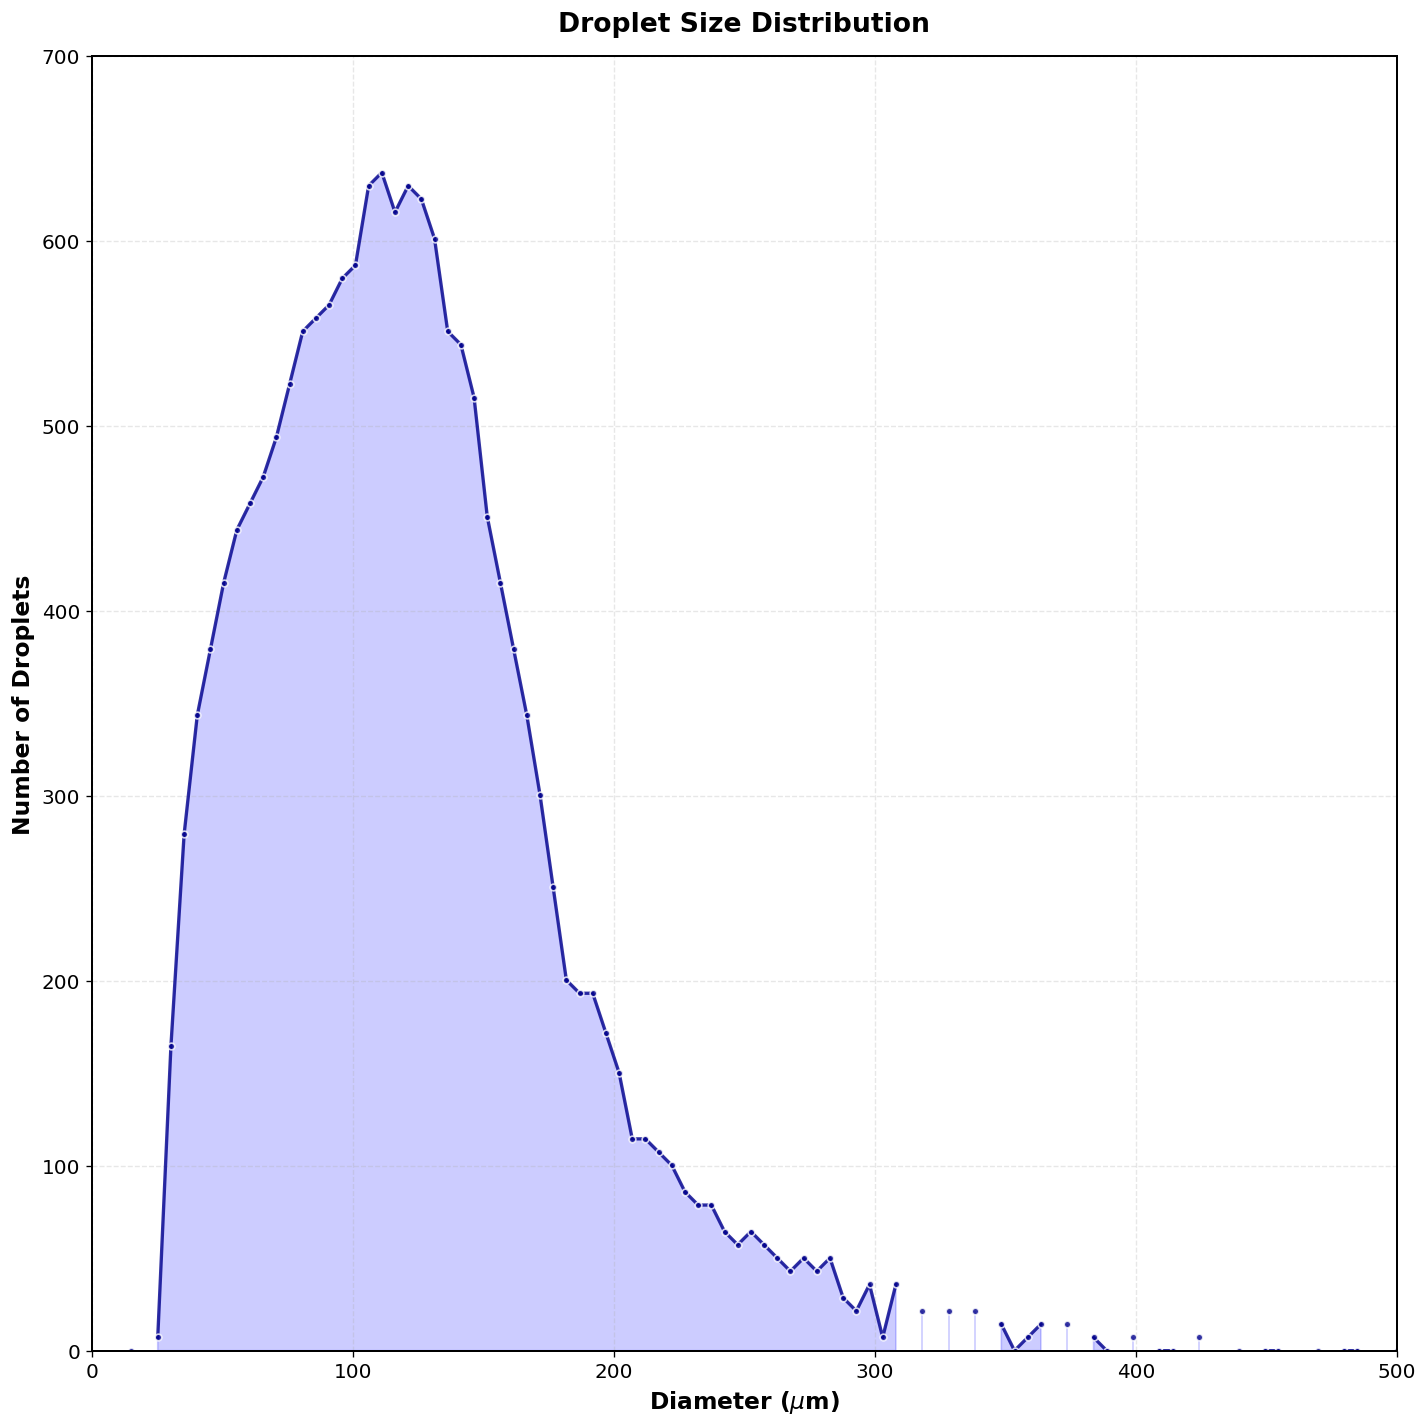

Y-axis range: [0, 700]
Curve maximum: 637.0 (target: 637.0)


In [35]:
# Plot with droplet diameter and count axes
fig, ax = plt.subplots(figsize=(12, 12), dpi=120)

# Rescale x to [0, 500] (no change needed to max value)
x_rescaled = (x_positions / x_positions.max()) * 500 if x_positions.max() > 0 else x_positions

# Rescale y so maximum is at 91% of 700 = 637
target_max = 0.91 * 700  # 637
y_rescaled = (heights_rescaled / np.nanmax(heights_rescaled)) * target_max if np.nanmax(heights_rescaled) > 0 else heights_rescaled

# Plot
ax.plot(x_rescaled, y_rescaled, 'o-', linewidth=2, color='darkblue', 
        markersize=4, markeredgewidth=1, markeredgecolor='white', alpha=0.8)
ax.fill_between(x_rescaled, 0, y_rescaled, alpha=0.2, color='blue')

# Labels and title
ax.set_title('Droplet Size Distribution', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Diameter ($\\mu$m)', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Droplets', fontsize=14, fontweight='bold')

# Axis limits (y-axis still goes to 700, but curve peaks at 637)
ax.set_xlim(0, 500)
ax.set_ylim(0, 700)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.grid(True, which='minor', alpha=0.15, linestyle=':', linewidth=0.5)

# Tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)

# Spine styling
for spine in ax.spines.values():
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.savefig('droplet_distribution.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print confirmation
print(f"Y-axis range: [0, 700]")
print(f"Curve maximum: {np.nanmax(y_rescaled):.1f} (target: {target_max:.1f})")

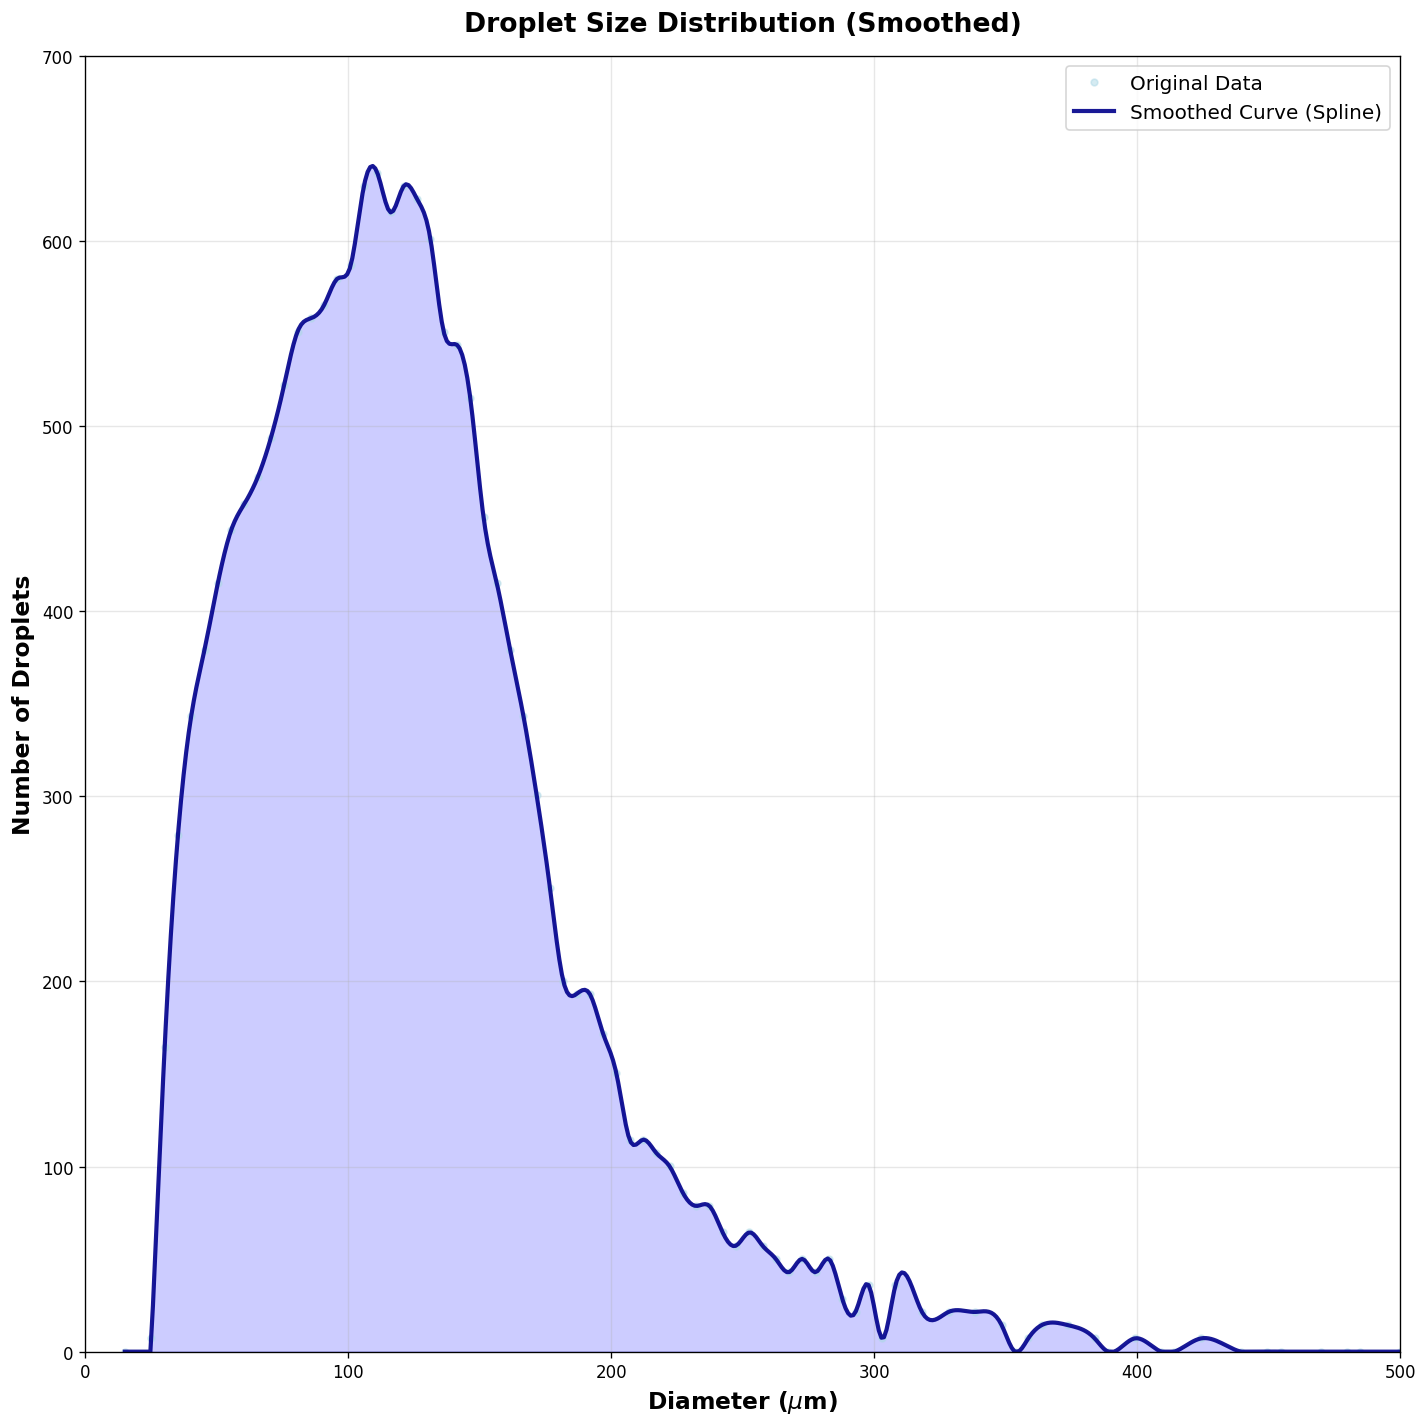

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, UnivariateSpline
from scipy.optimize import curve_fit

# ============================================================================
# METHOD 1: Spline Interpolation (Smooth Curve Through Points)
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 12), dpi=120)

x_valid = x_rescaled[valid_mask]
y_valid = y_rescaled[valid_mask]

# Create smooth spline
# Higher k = smoother curve
spline = make_interp_spline(x_valid, y_valid, k=3)  # Cubic spline

# Generate smooth curve with more points
x_smooth = np.linspace(x_valid.min(), x_valid.max(), 500)
y_smooth = spline(x_smooth)

# Ensure no negative values
y_smooth = np.maximum(y_smooth, 0)

# Plot original data
ax.plot(x_rescaled, y_rescaled, 'o', color='lightblue', 
        markersize=4, alpha=0.5, label='Original Data')

# Plot smooth fit
ax.plot(x_smooth, y_smooth, '-', linewidth=2.5, color='darkblue', 
        alpha=0.9, label='Smoothed Curve (Spline)')
ax.fill_between(x_smooth, 0, y_smooth, alpha=0.2, color='blue')

# Labels
ax.set_title('Droplet Size Distribution (Smoothed)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Diameter ($\\mu$m)', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Droplets', fontsize=14, fontweight='bold')
ax.set_xlim(0, 500)
ax.set_ylim(0, 700)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.savefig('droplet_distribution_smoothed.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
import numpy as np
from scipy.integrate import trapezoid

def calculate_volume_fraction(x_smooth, y_smooth, d_min, d_max):
    """
    Calculate the fraction of total droplet volume between two diameters
    
    Volume of sphere: V = (4/3)πr³ = (π/6)d³
    Total volume ∝ ∫ d³ · N(d) dd
    
    Parameters:
    -----------
    x_smooth : array
        Diameter values (μm)
    y_smooth : array
        Number of droplets at each diameter
    d_min : float
        Minimum diameter (μm)
    d_max : float
        Maximum diameter (μm)
        
    Returns:
    --------
    dict : Contains volume fraction and statistics
    """
    
    # Weight by volume (d³) since V ∝ d³
    volume_weighted = y_smooth * (x_smooth ** 3)
    
    # Total volume (integral over all diameters)
    total_volume = trapezoid(volume_weighted, x_smooth)
    
    # Find indices within the interval [d_min, d_max]
    mask = (x_smooth >= d_min) & (x_smooth <= d_max)
    
    # Volume in the interval
    interval_volume = trapezoid(volume_weighted[mask], x_smooth[mask])
    
    # Volume fraction
    volume_fraction = interval_volume / total_volume if total_volume > 0 else 0
    
    # Number fraction (for comparison)
    total_droplets = trapezoid(y_smooth, x_smooth)
    interval_droplets = trapezoid(y_smooth[mask], x_smooth[mask])
    number_fraction = interval_droplets / total_droplets if total_droplets > 0 else 0
    
    return {
        'volume_fraction': volume_fraction,
        'number_fraction': number_fraction,
        'interval_volume': interval_volume,
        'total_volume': total_volume,
        'interval_droplets': interval_droplets,
        'total_droplets': total_droplets,
        'd_min': d_min,
        'd_max': d_max
    }


def plot_volume_analysis(x_smooth, y_smooth, intervals, save_path=None):
    """
    Plot volume distribution with highlighted intervals
    
    Parameters:
    -----------
    x_smooth : array
        Diameter values
    y_smooth : array
        Number of droplets
    intervals : list of tuples
        List of (d_min, d_max) intervals to analyze
    save_path : str, optional
        Path to save figure
    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=120)
    
    # ========================================
    # Plot 1: Number distribution with intervals
    # ========================================
    ax1.plot(x_smooth, y_smooth, '-', linewidth=2.5, color='darkblue', 
             alpha=0.9, label='Number Distribution')
    ax1.fill_between(x_smooth, 0, y_smooth, alpha=0.2, color='blue')
    
    # Highlight intervals
    colors = plt.cm.Set3(np.linspace(0, 1, len(intervals)))
    
    for i, (d_min, d_max) in enumerate(intervals):
        mask = (x_smooth >= d_min) & (x_smooth <= d_max)
        ax1.fill_between(x_smooth[mask], 0, y_smooth[mask], 
                        alpha=0.5, color=colors[i], 
                        label=f'{d_min}-{d_max} μm')
    
    ax1.set_title('Droplet Number Distribution', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Diameter (μm)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Droplets', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11, loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 500)
    
    # ========================================
    # Plot 2: Volume distribution (weighted by d³)
    # ========================================
    volume_weighted = y_smooth * (x_smooth ** 3)
    
    ax2.plot(x_smooth, volume_weighted, '-', linewidth=2.5, color='darkred', 
             alpha=0.9, label='Volume Distribution')
    ax2.fill_between(x_smooth, 0, volume_weighted, alpha=0.2, color='red')
    
    # Highlight intervals
    for i, (d_min, d_max) in enumerate(intervals):
        mask = (x_smooth >= d_min) & (x_smooth <= d_max)
        ax2.fill_between(x_smooth[mask], 0, volume_weighted[mask], 
                        alpha=0.5, color=colors[i], 
                        label=f'{d_min}-{d_max} μm')
    
    ax2.set_title('Droplet Volume Distribution (weighted by d³)', 
                  fontsize=16, fontweight='bold')
    ax2.set_xlabel('Diameter (μm)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Volume Contribution (a.u.)', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11, loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 500)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"[Saved] Volume analysis → {save_path}")
    
    plt.show()


def print_volume_summary(x_smooth, y_smooth, intervals):
    """
    Print summary table of volume fractions
    """
    print("\n" + "="*80)
    print("DROPLET VOLUME ANALYSIS")
    print("="*80)
    print(f"{'Interval (μm)':<20} {'Volume %':<12} {'Number %':<12} {'V/N Ratio':<12}")
    print("-"*80)
    
    results = []
    for d_min, d_max in intervals:
        result = calculate_volume_fraction(x_smooth, y_smooth, d_min, d_max)
        results.append(result)
        
        v_pct = result['volume_fraction'] * 100
        n_pct = result['number_fraction'] * 100
        ratio = v_pct / n_pct if n_pct > 0 else 0
        
        print(f"{d_min:>6.0f} - {d_max:<6.0f}     {v_pct:>8.2f}%    {n_pct:>8.2f}%    {ratio:>8.2f}")
    
    print("-"*80)
    
    # Verify sum
    total_v = sum(r['volume_fraction'] for r in results) * 100
    total_n = sum(r['number_fraction'] for r in results) * 100
    print(f"{'TOTAL':<20} {total_v:>8.2f}%    {total_n:>8.2f}%")
    print("="*80)
    
    return results


DROPLET VOLUME ANALYSIS
Interval (μm)        Volume %     Number %     V/N Ratio   
--------------------------------------------------------------------------------
     0 - 50             0.14%        7.61%        0.02
    50 - 100            4.01%       29.91%        0.13
   150 - 200           22.92%       16.64%        1.38
   200 - 250           16.19%        5.39%        3.00
   350 - 400            6.76%        0.48%       14.20
   400 - 500            3.25%        0.16%       20.49
--------------------------------------------------------------------------------
TOTAL                   53.28%       60.18%
[Saved] Volume analysis → droplet_volume_analysis.pdf


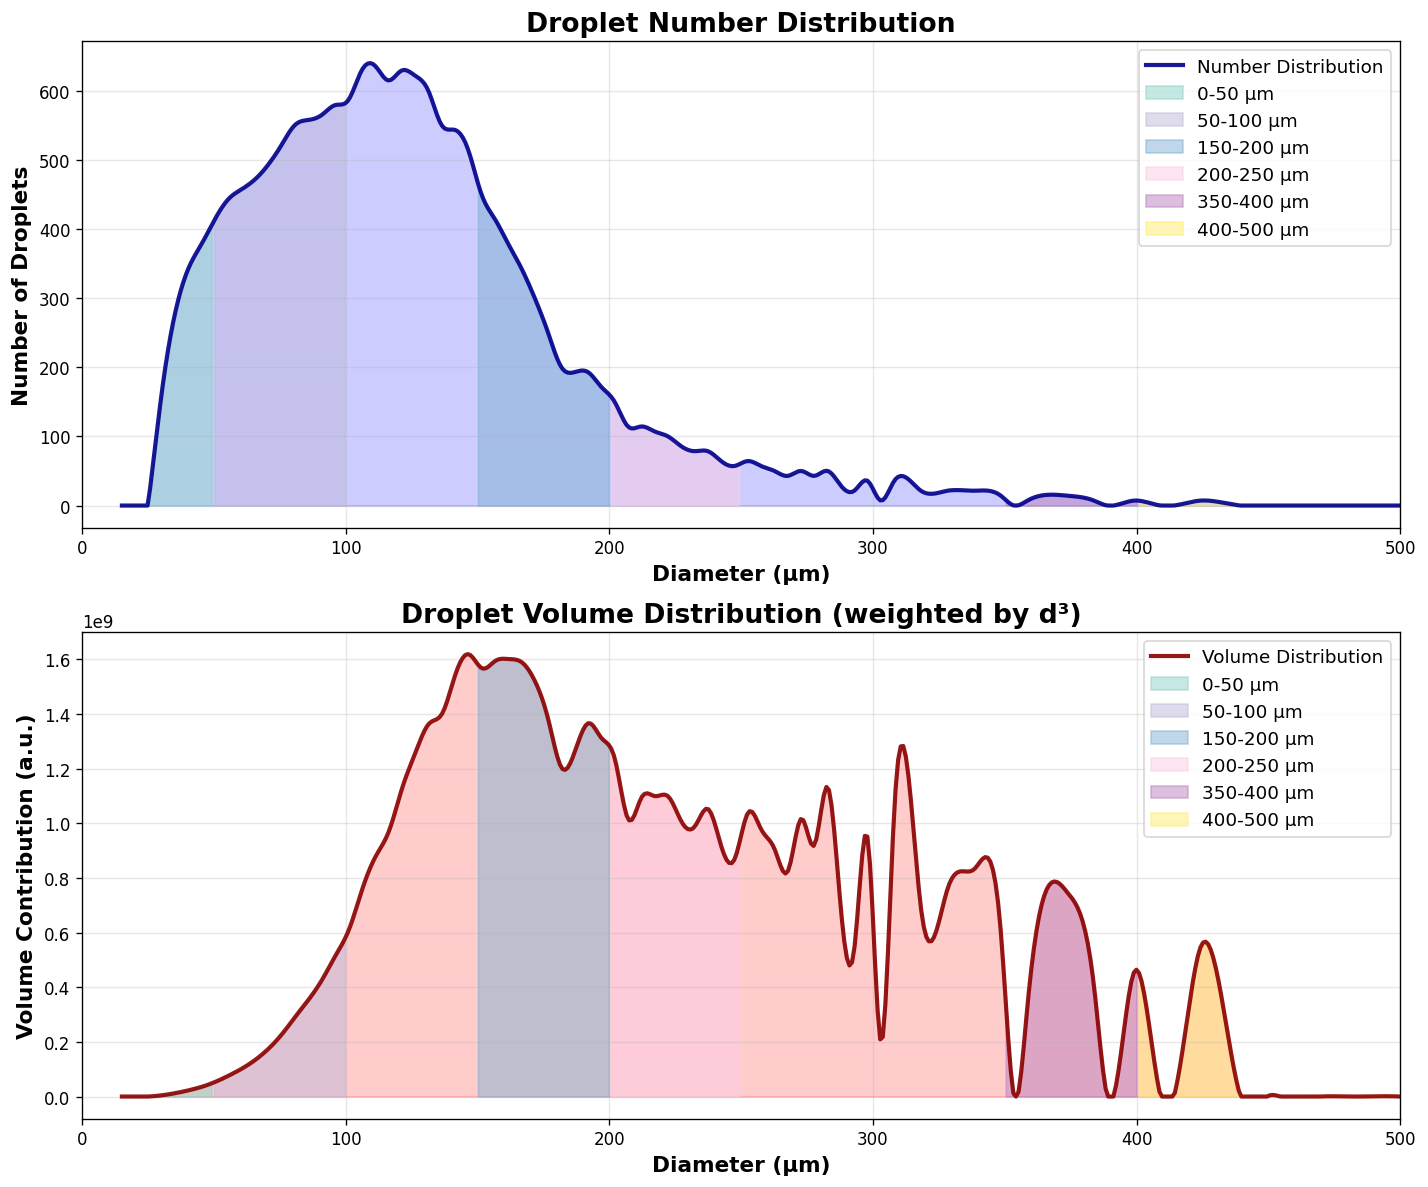


Droplets between 50-100 μm:
  Volume fraction: 4.01%
  Number fraction: 29.91%


In [38]:
# After creating your smoothed curve:
x_smooth, y_smooth = x_smooth, y_smooth  # Your smoothed data

# Define diameter intervals to analyze (in μm)
intervals = [
    (0, 50),      # Very small droplets
    (50, 100),    # Small droplets
    (150, 200),   # Medium droplets
    (200, 250),   # Large droplets
    (350, 400),
    (400, 500)    # Very large droplets
]

# Calculate and print results
results = print_volume_summary(x_smooth, y_smooth, intervals)

# Plot the analysis
plot_volume_analysis(x_smooth, y_smooth, intervals, 
                    save_path='droplet_volume_analysis.pdf')

# Access individual results
result_50_100 = calculate_volume_fraction(x_smooth, y_smooth, 50, 100)
print(f"\nDroplets between 50-100 μm:")
print(f"  Volume fraction: {result_50_100['volume_fraction']*100:.2f}%")
print(f"  Number fraction: {result_50_100['number_fraction']*100:.2f}%")

SIMULATED ANNEALING
Temperature: 4.00 → 0.10
Cooling steps: 10
Sweeps per temperature: 2
Cooling schedule: exponential
  [ 10.0%] T =  4.000, E =  16855.7, M =  0.395
        → Spin flips at this temperature: [4366244, 4365282]
  [ 20.0%] T =  2.655, E =  22799.9, M =  0.503
        → Spin flips at this temperature: [3146705, 3145511]
  [ 30.0%] T =  1.762, E =  26652.0, M =  0.568
        → Spin flips at this temperature: [1999402, 2001309]
  [ 40.0%] T =  1.170, E =  29050.3, M =  0.615
        → Spin flips at this temperature: [1085574, 1086260]
  [ 50.0%] T =  0.776, E =  29975.6, M =  0.639
        → Spin flips at this temperature: [605543, 604934]
  [ 60.0%] T =  0.515, E =  29624.3, M =  0.657
        → Spin flips at this temperature: [397017, 401099]
  [ 70.0%] T =  0.342, E =  29215.9, M =  0.668
        → Spin flips at this temperature: [278153, 276482]
  [ 80.0%] T =  0.227, E =  28897.9, M =  0.679
        → Spin flips at this temperature: [186878, 187229]
  [ 90.0%] T =  0

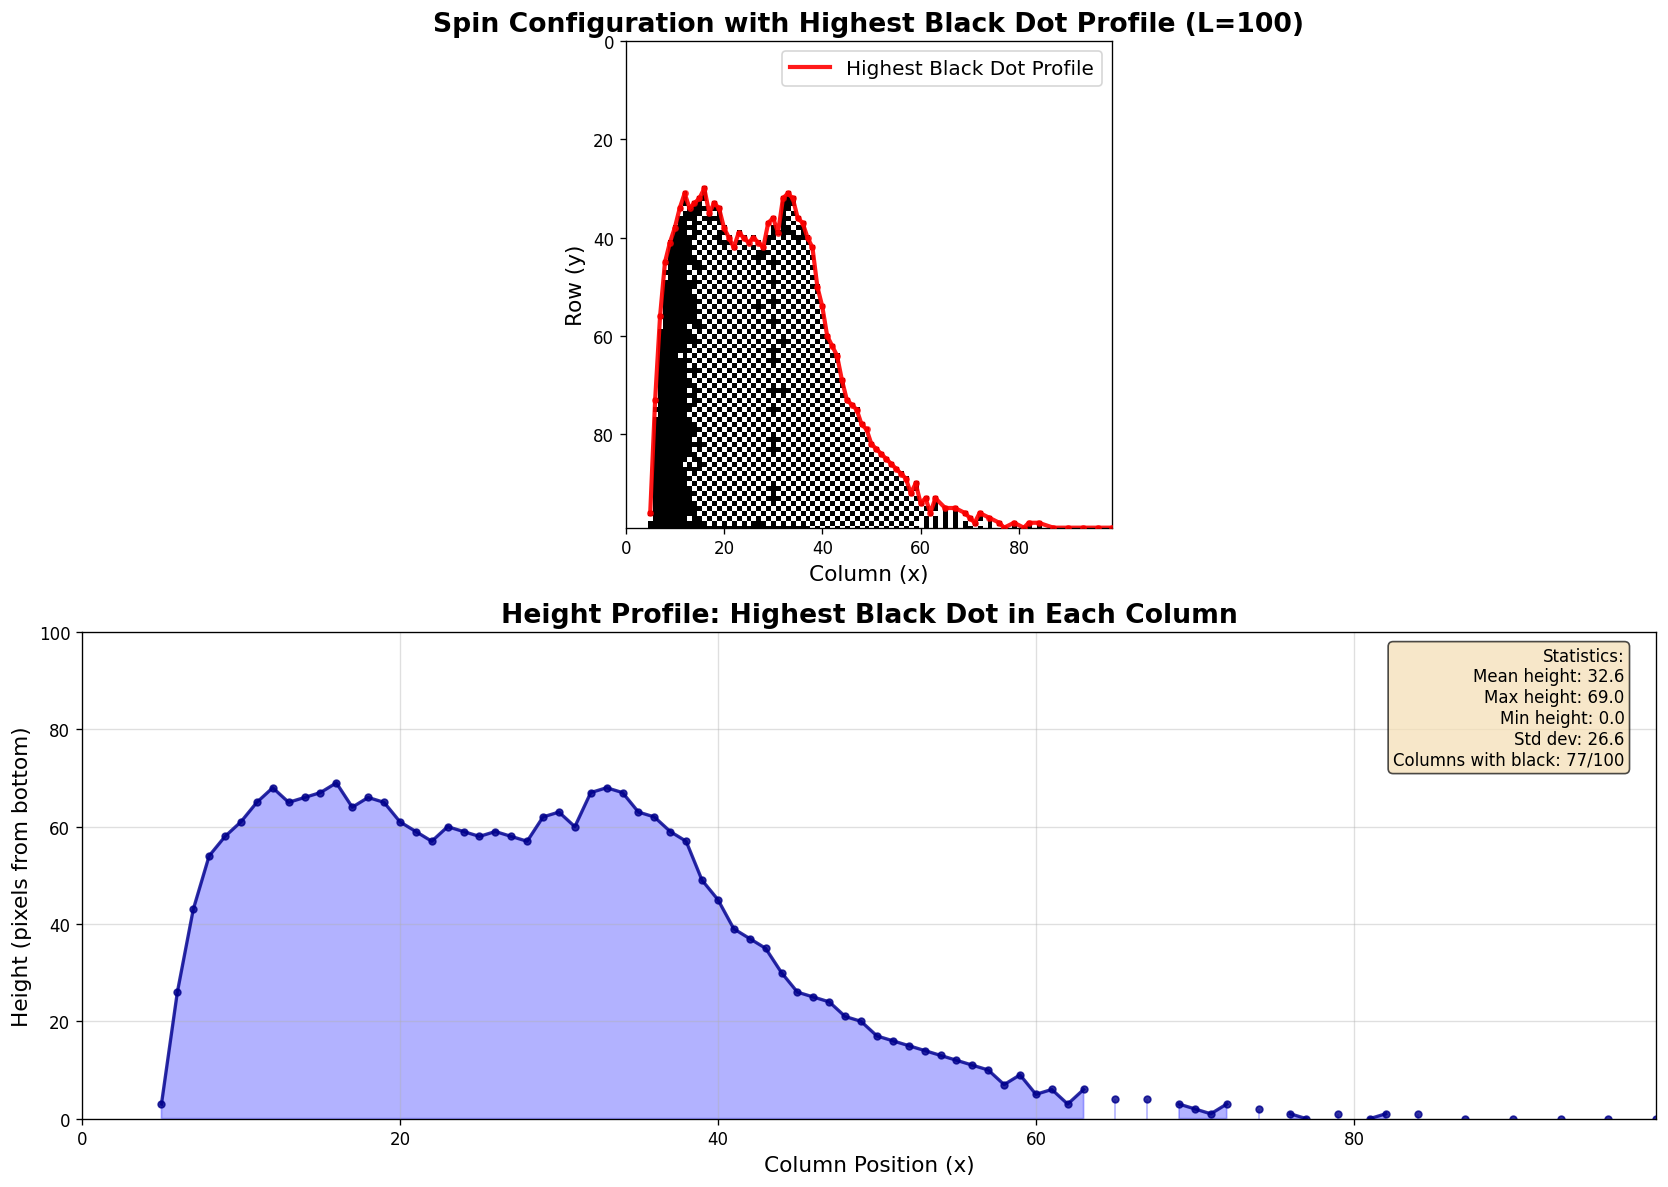


HIGHEST BLACK DOT PROFILE ANALYSIS
Lattice size: 100 × 100
Columns analyzed: 100
Columns with black dots: 77
Columns without black dots: 23

Height Statistics (from bottom):
  Mean: 32.65
  Median: 26.00
  Max: 69.00
  Min: 0.00
[Saved] Rescaled profile → red_plot_rescaled_profile.pdf


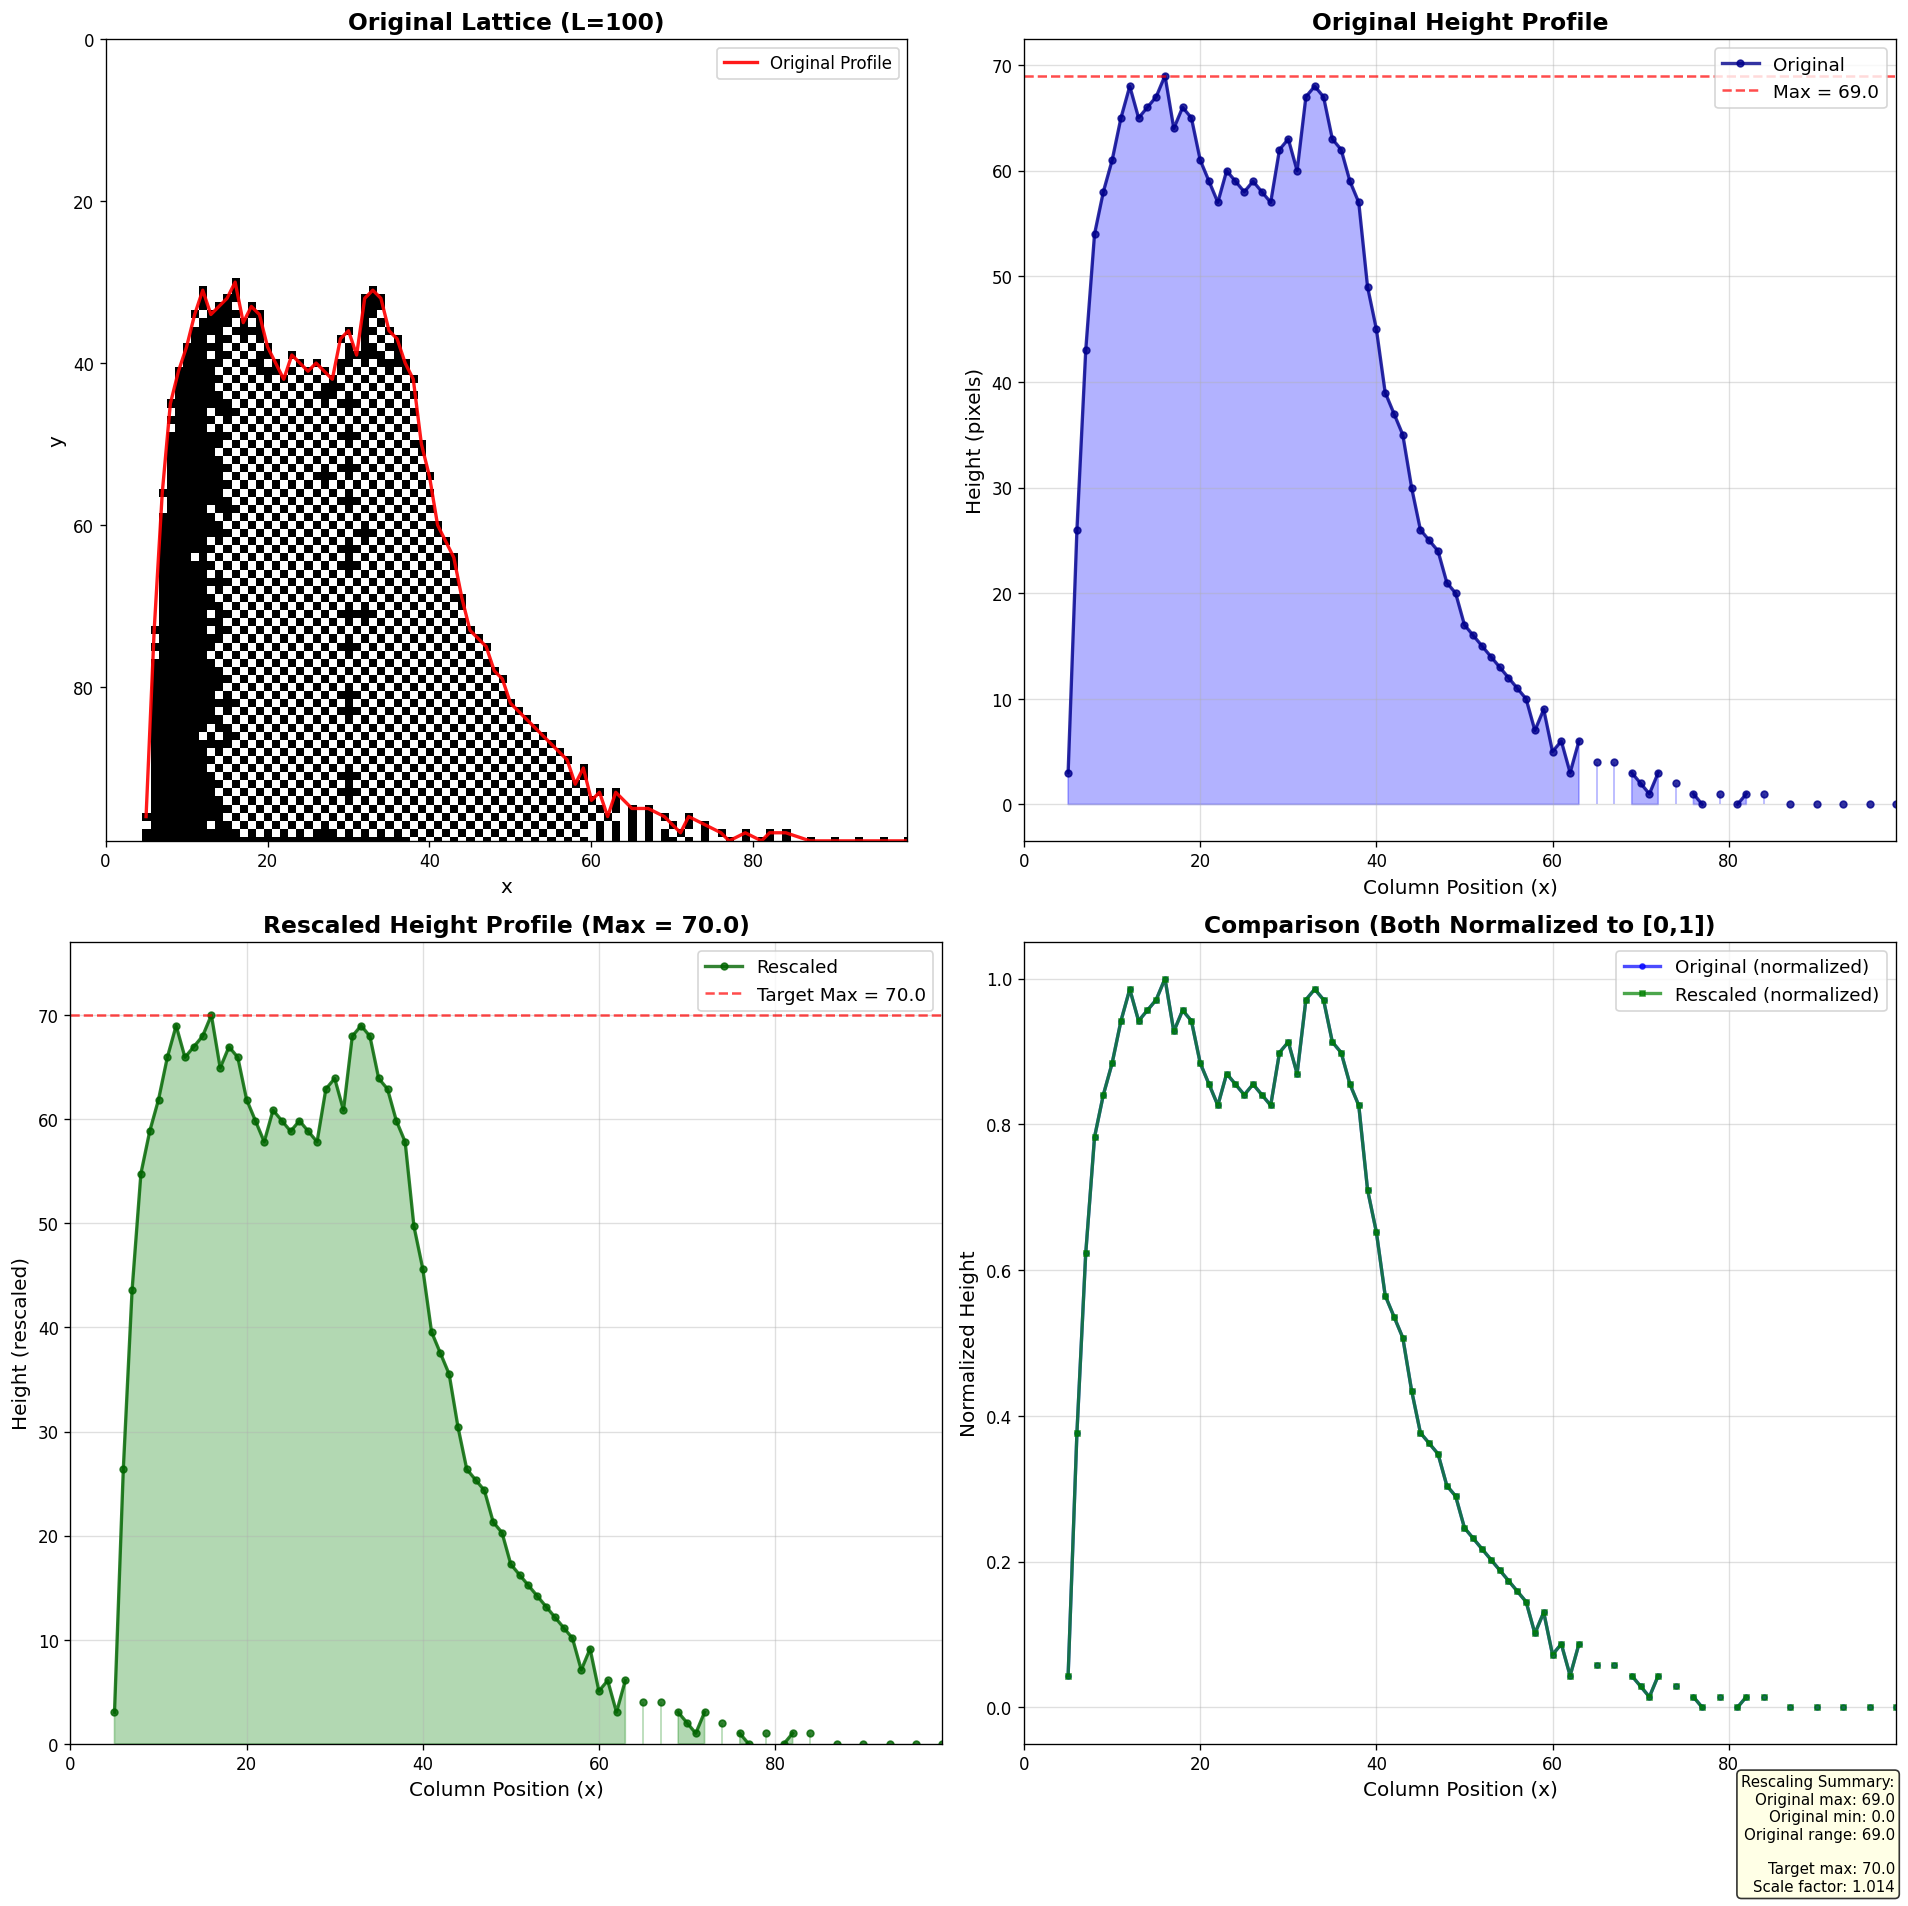


HEIGHT PROFILE RESCALING
Original height range: [0.00, 69.00]
Target maximum height: 70.00
Scale factor: 1.0145
Valid data points: 77/100


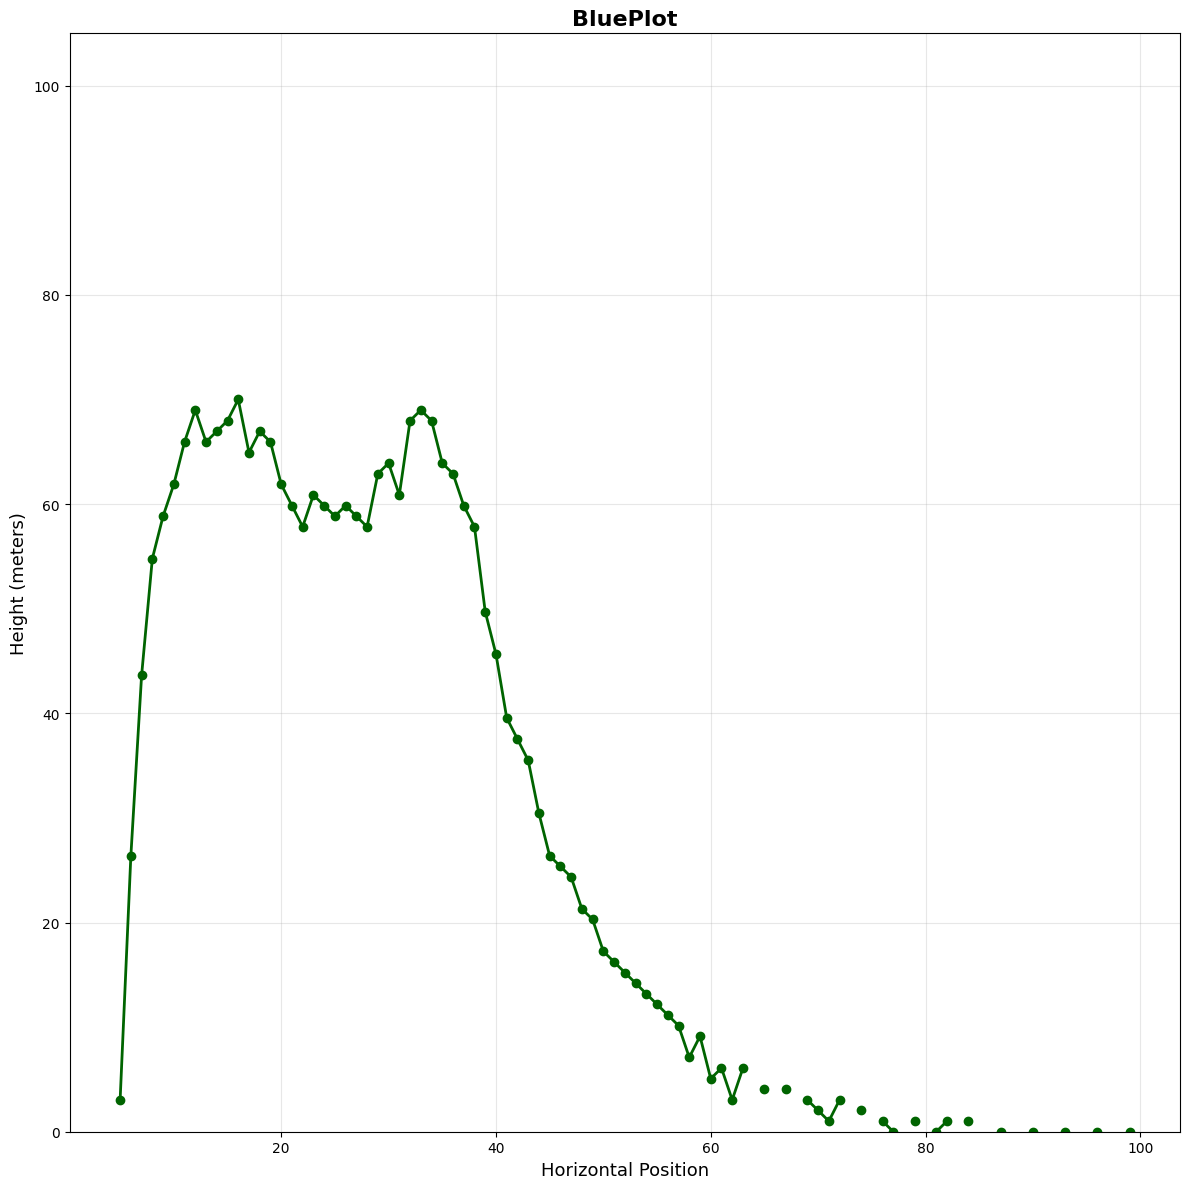

In [43]:
# Step 1: Run annealing
h_field, gray = load_image(
    "/Users/mattthew/Documents/GitHub/Comp-Sim-Numerical-Methods/IsingModel/picture to plot/red.plot.png", 
    L=100, h0=5.0
)

lattice2, temps2, energies2, mags2 = simulated_annealing(
    L=100, T_start=4.0, T_end=0.1, cooling_steps=10, sweeps_per_temp=2,
    h=h_field, J=-0.6, initial_state='random', cooling='exponential'
)

# Step 2: Extract profile
profile_data = plot_highest_black_dot_profile(
    lattice2,
    save_path='redPlot_profile.pdf'
)

# Step 3: Rescale to target height (e.g., 100 meters)
rescaled_data = rescale_profile_to_height(
    profile_data,
    target_max_height=100*(490/700),  # Target maximum height
    lattice=lattice2,
    save_path='red_plot_rescaled_profile.pdf'
)

# Step 4: Use the rescaled data
x_positions = rescaled_data['x_coords']
heights_rescaled = rescaled_data['rescaled_heights']

# Plot just the rescaled profile
plt.figure(figsize=(12, 12))
plt.plot(x_positions, heights_rescaled, 'o-', linewidth=2, color='darkgreen')
plt.title('BluePlot', fontsize=16, fontweight='bold')
plt.xlabel('Horizontal Position', fontsize=13)
plt.ylabel('Height (meters)', fontsize=13)
plt.grid(True, alpha=0.3)
plt.ylim(0, 105)
plt.tight_layout()
plt.show()

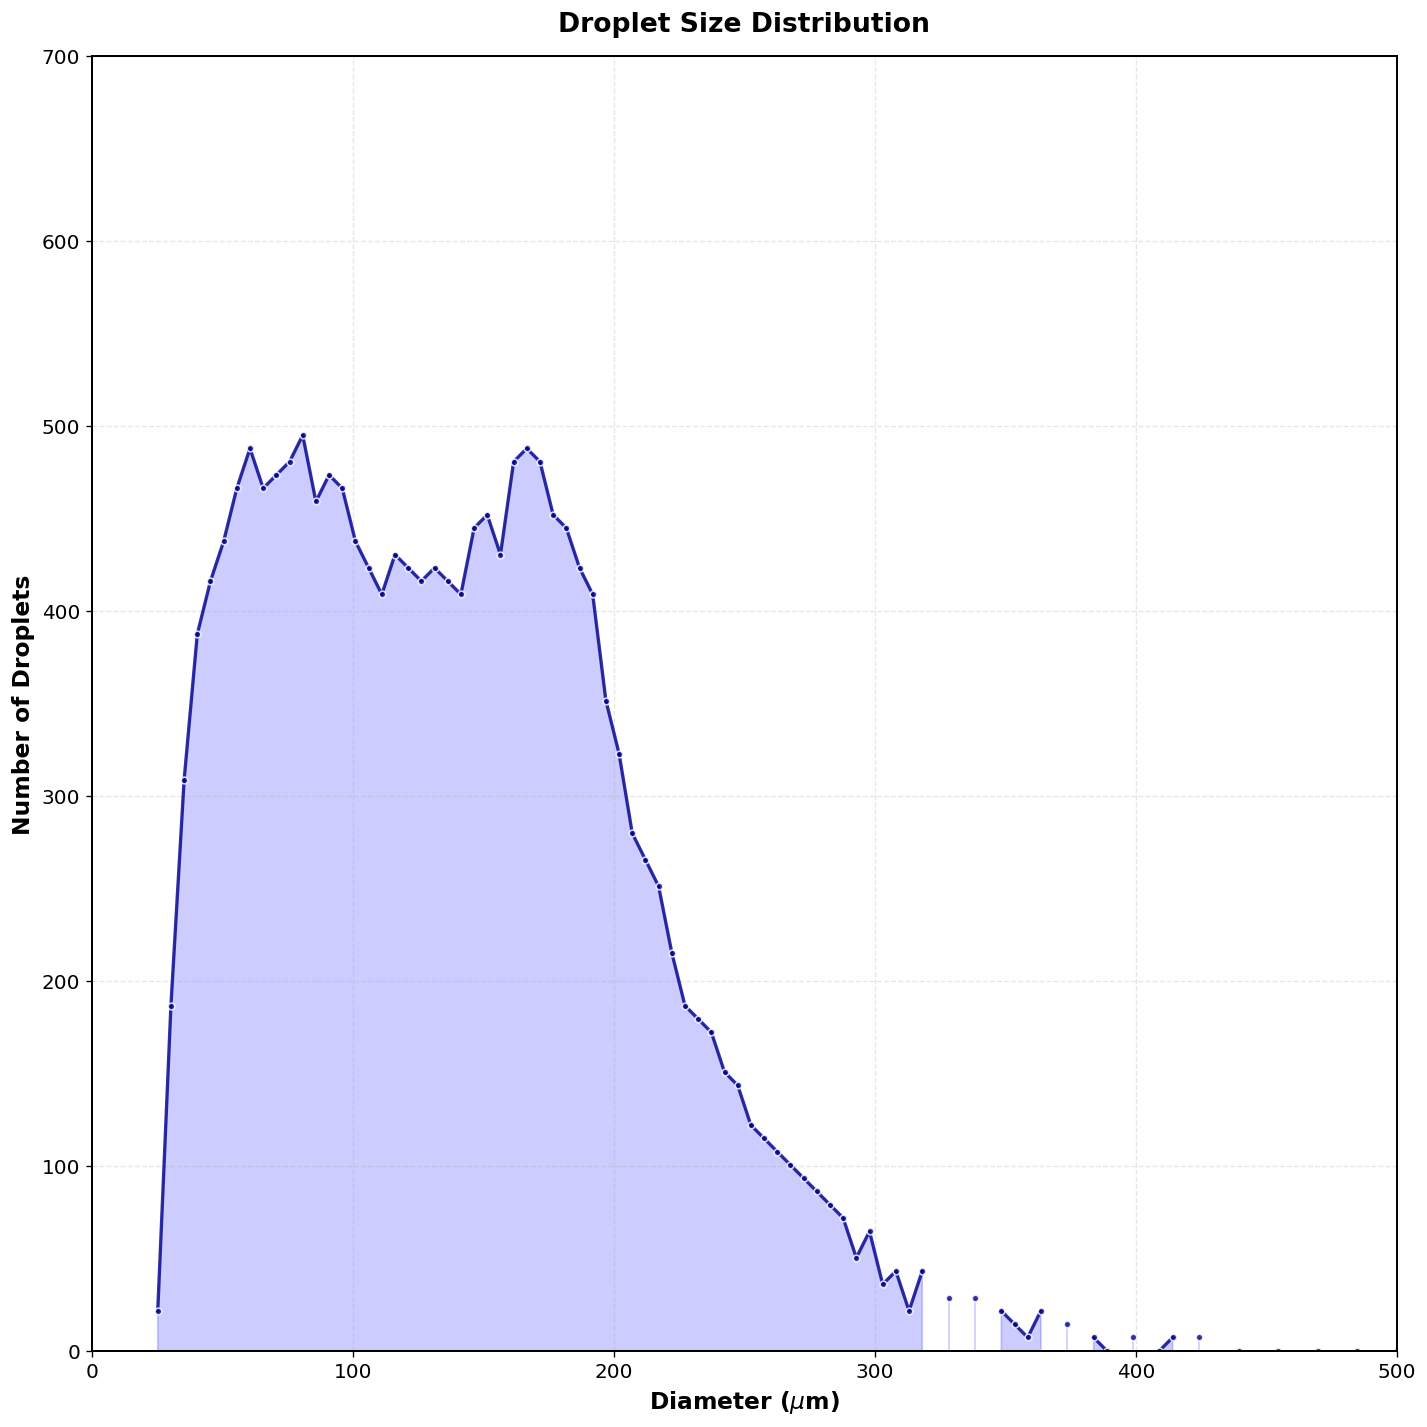

Y-axis range: [0, 700]
Curve maximum: 495.0 (target: 495.0)


In [46]:
# Plot with droplet diameter and count axes
fig, ax = plt.subplots(figsize=(12, 12), dpi=120)

# Rescale x to [0, 500] (no change needed to max value)
x_rescaled = (x_positions / x_positions.max()) * 500 if x_positions.max() > 0 else x_positions

# Rescale y so maximum is at 91% of 700 = 637
target_max = 495  # 637
y_rescaled = (heights_rescaled / np.nanmax(heights_rescaled)) * target_max if np.nanmax(heights_rescaled) > 0 else heights_rescaled

# Plot
ax.plot(x_rescaled, y_rescaled, 'o-', linewidth=2, color='darkblue', 
        markersize=4, markeredgewidth=1, markeredgecolor='white', alpha=0.8)
ax.fill_between(x_rescaled, 0, y_rescaled, alpha=0.2, color='blue')

# Labels and title
ax.set_title('Droplet Size Distribution', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Diameter ($\\mu$m)', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Droplets', fontsize=14, fontweight='bold')

# Axis limits (y-axis still goes to 700, but curve peaks at 637)
ax.set_xlim(0, 500)
ax.set_ylim(0, 700)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.grid(True, which='minor', alpha=0.15, linestyle=':', linewidth=0.5)

# Tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)

# Spine styling
for spine in ax.spines.values():
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.savefig('droplet_distribution.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print confirmation
print(f"Y-axis range: [0, 700]")
print(f"Curve maximum: {np.nanmax(y_rescaled):.1f} (target: {target_max:.1f})")